In [1]:
from tqdm import tqdm
import multiprocessing as mlp
import time
import pickle
import swifter
import lightgbm as lgb
from random import seed
import os
import gc
import sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import time, datetime
import pdb, traceback
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle

/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# train test

In [2]:
all_files = pd.read_csv("../data/train.csv")
test_files = pd.read_csv("../data/test.csv")

In [69]:
all_files = pd.read_csv("./dataset/final_train.csv")
test_files = pd.read_csv("./dataset/final_test.csv")

In [16]:
print(len(all_files),len(test_files))

400000 100000


In [207]:
all_files.head()

NameError: name 'all_files' is not defined

In [24]:
test_files.head()

,Id_y,Target
0,../data/test_part/0/086741.txt,0
1,../data/test_part/0/036424.txt,0
2,../data/test_part/0/073183.txt,0
3,../data/test_part/0/088660.txt,0
4,../data/test_part/0/036162.txt,0


In [18]:
test_files['Id'] = test_files['Id'].swifter.apply(lambda x: str(x).zfill(6))
test_files.head()

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 428000.25it/s]


,Id,Target
0,000000,0
1,000001,0
2,000002,0
3,000003,0
4,000004,0


In [3]:
train_txt = []
for root, dirs, files in os.walk("../data/train_part/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file.split("_")
        train_txt.append([filePath, CategoryID[:3]])

test_txt = []
for root, dirs, files in os.walk("../data/test_part/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file, "000"
        test_txt.append([filePath, CategoryID[:3]])

In [4]:
all_files = pd.DataFrame(train_txt, columns=["Id_y", "Target"])
all_files.Target = pd.to_numeric(all_files.Target)

test_files = pd.DataFrame(test_txt, columns=["Id_y", "Target"])
test_files.Target = pd.to_numeric(test_files.Target)

In [63]:
# 用字典查询代替类型转换，可以减少一部分计算时间
date2position = {}
datestr2dateint = {}
str2int = {}

for i in range(24):
    str2int[str(i).zfill(2)] = i

# 访问记录内的时间从2018年10月1日起，共182天
# 10.1 % 7 == 1
# 将日期按日历排列
for i in range(182):
    date = datetime.date(day=1, month=10, year=2018)+datetime.timedelta(days=i)
    date_int = int(date.__str__().replace("-", ""))
    date2position[date_int] = [i%7, i//7]
    datestr2dateint[str(date_int)] = date_int

In [11]:
def get_len(x, s_type="train"):
    table = pd.read_csv(x, header=None, sep="\t")
    return len(table)

def get_day(data, s_type="train"):
    table = pd.read_csv(data["Id_y"], header=None, sep="\t")
    init = np.zeros((len(table), 24))
    for k, string in enumerate(table[1]):
        temp = []
        for item in string.split(','):
            temp.append([item[0:8], item[9:].split("|")])
        for date, visit_lst in temp:
            x, y = date2position[datestr2dateint[date]]
            for visit in visit_lst: # 统计到访的总人数
                init[k][str2int[visit]] += 1
    day_num = np.sum(init, axis=0)
    for i in range(24):
        data['hour_'+str(i)] = day_num[i]
    return data

def get_day7(data, s_type="train"):
    table = pd.read_csv(data["Id_y"], header=None, sep="\t")
    init = np.zeros((len(table), 7))
    for k, string in enumerate(table[1]):
        temp = []
        for item in string.split(','):
            temp.append([item[0:8], item[9:].split("|")])
        for date, visit_lst in temp:
            x, y = date2position[datestr2dateint[date]]
            for visit in visit_lst: # 统计到访的总人数
                init[k][x] += 1
    day_num = np.sum(init, axis=0)
    for i in range(7):
        data['day_'+str(i)] = day_num[i]
    return data

In [63]:
string = "20181010&14,20181011&12|13|14|15|16,20181012&10|11,20181015&12|13|14|15|16|17,20181016&15|16|17,20181017&11|12|13,20181019&10|14,20181021&13,20181029&10,20181030&08|09|10|11|12|13|14,20181102&09|10|11|12|15,20181105&08|09|10|11|12|13|14|15|16|17|18,20181126&16|17"

In [67]:
string.split(',')

['20181010&14',
 '20181011&12|13|14|15|16',
 '20181012&10|11',
 '20181015&12|13|14|15|16|17',
 '20181016&15|16|17',
 '20181017&11|12|13',
 '20181019&10|14',
 '20181021&13',
 '20181029&10',
 '20181030&08|09|10|11|12|13|14',
 '20181102&09|10|11|12|15',
 '20181105&08|09|10|11|12|13|14|15|16|17|18',
 '20181126&16|17']

In [83]:
table = np.loadtxt(all_files.Id_y[0], delimiter="\t", dtype="str")
for k, string in table:
    print(k, string)

f066a5b3169096f7 20190304&09|10|11|12|13|14|15|17|18,20190305&07|08|12|13,20190306&12|13|17,20190307&07|08|13|14|15
916b675070adcb93 20181008&10|11|13|18|19|20,20181009&10|11,20181010&18|19|20,20181011&11|19|20,20181015&11|12|16|19,20181017&11|12|16|17|18|19|20,20181018&10|20,20181019&20,20181022&11,20181024&17|18|19|20,20181026&09|11|12|18|20,20181029&17,20181030&10|16|18,20181101&11|20,20181102&16|20,20181106&16|20,20181108&20,20181109&19|20,20181110&10,20181112&10|11|16,20181115&16|19,20181116&14|17|19,20181119&10|11|17|19,20181120&19,20181122&09|18,20181123&10,20181126&10|11,20181128&10|11,20181129&10|11,20181203&10|11|12|13|19,20181204&19,20181205&20,20181206&10|11,20181207&16,20181211&12,20181213&10,20181214&10|13|20,20181218&16,20181219&16|20,20181220&11|12|13,20181221&19|20,20181224&13|18|19,20181225&11|16|18,20181227&16|17|18,20181228&13|16|17|18|19,20181229&13|14|16,20190103&10|16,20190219&12,20190221&11,20190222&11|16,20190227&16
21ccf2b53e6bb13e 20181003&13|14,20181004&22|2

In [90]:
print(count)

7


In [ ]:
count = 0
for i in "20181107&18,20181108&17|18,20181112&18,20181123&18,20181214&17,20181228&18".split(","):
    count += i[9:].count("|")+1

In [6]:
def array2pkl(path, array):
    with open(path, 'wb') as f:
        pickle.dump(array, f)
        
def get_userinfo(x, s_type="train"):
#     table = np.loadtxt(x, delimiter="\t", dtype="str")
#     _path = x.replace("train", "trainpkl").replace("test", "testpkl").replace("txt", "pkl")
#     if os.path.exists(_path):
# #         print("存在")
#         with open(_path, "rb") as f:
#             temp = pickle.load(f)
#         return stat_features(temp["lens"])
#     else:
    table = pd.read_csv(x, sep="\t", header=None)
    temp = {}
    temp["lens"] = []
    temp["h_num"] = []
    temp["h_numOlens"] = []
    for string in table[1]:
#         k, string = row[0], row[1]
#         if k not in temp.keys():
#             temp[k] = {}
        u_len = string.count("&")
        temp["lens"].append(u_len)
        h_num = 0
        for item in string.split(','):
            h_num += item[9:].count("|")+1
        temp["h_num"].append(h_num)
        if u_len:
            temp["h_numOlens"].append(h_num/u_len)
        else:
            print(x)
            temp["h_numOlens"].append(h_num/(u_len+1))
#                 _d = item[0:8]
#                 temp[k][_d] = item[9:].split("|")

#         _dir = os.path.dirname(_path)
#         if not os.path.exists(_dir):
#             print("making dir:", _dir)
#             os.makedirs(_dir)
#         array2pkl(_path, temp)
    return stat_features(temp["lens"]) + stat_features(temp["h_num"]) + stat_features(temp["h_numOlens"])

In [7]:
def multi_task(data, s_type):
    data["stats"] =  data['Id_y'].swifter.apply(lambda x: get_userinfo(x,s_type))
#     with tqdm(data.Id_y) as t:
#         for path in t:
#             get_userinfo(path, s_type)
#     t.close()
    return data

In [26]:
def multi_task(data,s_type,i):
    data['len'] = data['Id_y'].swifter.apply(lambda x: get_len(x,s_type))
    data = data.swifter.apply(lambda x: get_day(x,s_type))
    data = data.swifter.apply(lambda x: get_day7(x,s_type))
    return data

In [60]:
from multiprocessing.dummy import Pool as ThreadPool

In [8]:
def stat_features(arr):
    if len(arr) != 0:
        return [max(arr), min(arr), np.mean(arr), np.ptp(arr), np.std(arr), np.median(arr)]
    else:
        return None

In [94]:
multi_task(task_train, "train")

KeyError: 1

In [9]:
# train
t0 = time.time()
N = all_files.shape[0]
print(N)
num_cpu = 20 # cpu数量
pool = mlp.Pool(num_cpu)

results = []
batch_num = N // num_cpu
print('batch_num',batch_num)
for i in range(num_cpu):
    if i == num_cpu-1:
        offset = N
    else:
        offset = (i+1)*batch_num
    task_train = all_files.iloc[i*batch_num : offset]
    print('task',i,'shape',len(task_train))
    result = pool.apply_async(multi_task,(task_train,'train'))
    results.append(result)
pool.close()
pool.join()
print('finished',len(results))

t1 = time.time()
print('time', int(t1 - t0), 's')

400000
batch_num 20000
task 0 shape 20000
task 1 shape 20000
task 2 shape 20000
task 3 shape 20000
task 4 shape 20000
task 5 shape 20000
task 6 shape 20000
task 7 shape 20000
task 8 shape 20000
task 9 shape 20000
task 10 shape 20000
task 11 shape 20000
task 12 shape 20000
task 13 shape 20000
task 14 shape 20000
task 15 shape 20000
task 16 shape 20000
task 17 shape 20000
task 18 shape 20000
task 19 shape 20000


Pandas Apply: 100%|██████████| 20000/20000 [05:16<00:00, 63.16it/s]


finished 20
time 357 s


In [10]:
trains = pd.DataFrame()
for result in tqdm(results):
    trains = pd.concat([trains, result.get()])
print(trains.shape[0])

100%|██████████| 20/20 [00:00<00:00, 18.81it/s]

400000


In [21]:
trains.head()

,Id_y,Target,stats,stats_len,stats_arr
0,../data/train_part/0/193260_002.txt,2,"[122, 2, 9.758620689655173, 120, 18.8099787146...",18,"[122, 2, 9.758620689655173, 120, 18.8099787146..."
1,../data/train_part/0/124280_007.txt,7,"[176, 2, 17.981974248927038, 174, 33.655163962...",18,"[176, 2, 17.981974248927038, 174, 33.655163962..."
2,../data/train_part/0/393290_008.txt,8,"[146, 2, 10.384895833333333, 144, 19.486968962...",18,"[146, 2, 10.384895833333333, 144, 19.486968962..."
3,../data/train_part/0/212900_008.txt,8,"[105, 2, 9.770750988142293, 103, 12.8162297609...",18,"[105, 2, 9.770750988142293, 103, 12.8162297609..."
4,../data/train_part/0/154600_005.txt,5,"[11, 2, 6.666666666666667, 9, 3.68178700572908...",18,"[11, 2, 6.666666666666667, 9, 3.68178700572908..."


In [27]:
stats_tr = np.zeros((400000, 18))
for i, _arr in enumerate(trains.stats_arr.values):
    stats_tr[i] = np.array(_arr)

In [31]:
features_user_feature = ["day_len_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median"]] +\
                        ["one_num_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median"]] +\
                        ["numOlen_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median"]]

In [33]:
user_stats = pd.DataFrame(stats_tr, columns=features_user_feature)
user_stats.head()

trains[features_user_feature] = user_stats.loc[:, features_user_feature].copy()
trains.drop(columns=["stats", "stats_len", "stats_arr"], inplace=True)

In [41]:
trains.head()

,Id_y,Target,day_len_max,day_len_min,day_len_mean,day_len_ptp,day_len_std,day_len_median,one_num_max,one_num_min,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,../data/train_part/0/193260_002.txt,2,122.0,2.0,9.758621,120.0,18.809979,3.0,1315.0,2.0,48.287356,1313.0,175.492143,8.0,15.114943,1.0,2.783275,14.114943,2.399258,2.000000
1,../data/train_part/0/124280_007.txt,7,176.0,2.0,17.981974,174.0,33.655164,4.0,3525.0,2.0,135.031760,3523.0,343.770422,15.0,20.125000,1.0,4.766268,19.125000,3.936084,3.333333
2,../data/train_part/0/393290_008.txt,8,146.0,2.0,10.384896,144.0,19.486969,3.0,1541.0,2.0,52.500000,1539.0,142.242355,9.0,22.500000,1.0,3.620208,21.500000,3.037970,2.500000
3,../data/train_part/0/212900_008.txt,8,105.0,2.0,9.770751,103.0,12.816230,5.0,758.0,2.0,24.879447,756.0,61.286111,8.0,16.100000,1.0,2.063005,15.100000,1.695594,1.500000
4,../data/train_part/0/154600_005.txt,5,11.0,2.0,6.666667,9.0,3.681787,7.0,18.0,2.0,9.666667,16.0,6.548961,9.0,1.636364,1.0,1.307359,0.636364,0.260245,1.285714


In [42]:
# test
t0 = time.time()
N = test_files.shape[0]
print(N)
num_cpu = 20 # cpu数量
pool = mlp.Pool(num_cpu)#

results = []
batch_num = N // num_cpu
print('batch_num',batch_num)
for i in range(num_cpu):
    if i == num_cpu-1:
        offset = N
    else:
        offset = (i+1)*batch_num
    task_train = test_files.iloc[i*batch_num : offset]
    print('task',i,'shape',len(task_train))
    result = pool.apply_async(multi_task,(task_train,'test'))
    results.append(result)
pool.close()
pool.join()
print('finished',len(results))

tests = pd.DataFrame()
for result in tqdm(results):
    tests = pd.concat([tests, result.get()])

t1 = time.time()
print('time', int(t1 - t0), 's')
print(tests.shape[0])

100000
batch_num 5000
task 0 shape 5000
task 1 shape 5000
task 2 shape 5000
task 3 shape 5000
task 4 shape 5000
task 5 shape 5000
task 6 shape 5000
task 7 shape 5000
task 8 shape 5000
task 9 shape 5000
task 10 shape 5000
task 11 shape 5000
task 12 shape 5000
task 13 shape 5000
task 14 shape 5000
task 15 shape 5000
task 16 shape 5000
task 17 shape 5000
task 18 shape 5000
task 19 shape 5000


100%|██████████| 20/20 [00:00<00:00, 133.89it/s]

finished 20
time 123 s
100000


In [43]:
tests = pd.DataFrame()
for result in tqdm(results):
    tests = pd.concat([tests, result.get()])
print(tests.shape[0])

100%|██████████| 20/20 [00:00<00:00, 116.78it/s]

100000


In [44]:
tests.head()

,Id_y,Target,stats
0,../data/test_part/0/086741.txt,0,"[169, 2, 15.158153241650295, 167, 28.339395776..."
1,../data/test_part/0/036424.txt,0,"[170, 2, 14.631578947368421, 168, 27.115867697..."
2,../data/test_part/0/073183.txt,0,"[163, 2, 3.925925925925926, 161, 8.17173762515..."
3,../data/test_part/0/088660.txt,0,"[59, 2, 11.057692307692308, 57, 13.47563822027..."
4,../data/test_part/0/036162.txt,0,"[145, 2, 27.166333666333667, 143, 33.954585722..."


In [45]:
stats_tr = np.zeros((100000, 18))
for i, _arr in enumerate(tests.stats.values):
    stats_tr[i] = np.array(_arr)

In [46]:
user_stats = pd.DataFrame(stats_tr, columns=features_user_feature)
user_stats.head()

,day_len_max,day_len_min,day_len_mean,day_len_ptp,day_len_std,day_len_median,one_num_max,one_num_min,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,169.0,2.0,15.158153,167.0,28.339396,4.0,2320.0,2.0,103.924361,2318.0,272.263771,15.5,19.600000,1.0,4.576454,18.600000,3.731945,3.000000
1,170.0,2.0,14.631579,168.0,27.115868,4.0,1984.0,2.0,83.827068,1982.0,244.681487,11.0,16.447368,1.0,3.375394,15.447368,2.771816,2.405882
2,163.0,2.0,3.925926,161.0,8.171738,2.0,1812.0,2.0,10.280280,1810.0,64.249806,3.0,11.116564,1.0,1.620309,10.116564,1.077519,1.500000
3,59.0,2.0,11.057692,57.0,13.475638,6.5,428.0,2.0,55.846154,426.0,89.728948,17.0,13.833333,1.0,3.738497,12.833333,2.965905,2.607143
4,145.0,2.0,27.166334,143.0,33.954586,9.0,2244.0,2.0,215.542957,2242.0,375.622873,28.0,22.000000,1.0,4.748570,21.000000,3.923046,3.500000


In [47]:
tests[features_user_feature] = user_stats.loc[:, features_user_feature].copy()
tests.drop(columns=["stats"], inplace=True)

In [52]:
tests.head()

,Id_y,Target,day_len_max,day_len_min,day_len_mean,day_len_ptp,day_len_std,day_len_median,one_num_max,one_num_min,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,../data/test_part/0/086741.txt,0,169.0,2.0,15.158153,167.0,28.339396,4.0,2320.0,2.0,103.924361,2318.0,272.263771,15.5,19.600000,1.0,4.576454,18.600000,3.731945,3.000000
1,../data/test_part/0/036424.txt,0,170.0,2.0,14.631579,168.0,27.115868,4.0,1984.0,2.0,83.827068,1982.0,244.681487,11.0,16.447368,1.0,3.375394,15.447368,2.771816,2.405882
2,../data/test_part/0/073183.txt,0,163.0,2.0,3.925926,161.0,8.171738,2.0,1812.0,2.0,10.280280,1810.0,64.249806,3.0,11.116564,1.0,1.620309,10.116564,1.077519,1.500000
3,../data/test_part/0/088660.txt,0,59.0,2.0,11.057692,57.0,13.475638,6.5,428.0,2.0,55.846154,426.0,89.728948,17.0,13.833333,1.0,3.738497,12.833333,2.965905,2.607143
4,../data/test_part/0/036162.txt,0,145.0,2.0,27.166334,143.0,33.954586,9.0,2244.0,2.0,215.542957,2242.0,375.622873,28.0,22.000000,1.0,4.748570,21.000000,3.923046,3.500000


# feature

In [32]:
p = ['hour_'+str(i) for i in range(24)]
q = ['day_'+str(i) for i in range(7)]

In [33]:
def get_argmax_p(data):
    return np.argmax(data[p])
trains['argmax_p'] = trains[p].swifter.apply(lambda x: get_argmax_p(x), axis=1)
trains['argmax_p'] = trains['argmax_p'].swifter.apply(lambda x: int(str(x).split('_')[1]))
tests['argmax_p'] = tests[p].swifter.apply(lambda x: get_argmax_p(x), axis=1)
tests['argmax_p'] = tests['argmax_p'].swifter.apply(lambda x: int(str(x).split('_')[1]))
def get_argmax_q(data):
    return np.argmax(data[q])
trains['argmax_q'] = trains[q].swifter.apply(lambda x: get_argmax_q(x), axis=1)
trains['argmax_q'] = trains['argmax_q'].swifter.apply(lambda x: int(str(x).split('_')[1]))
tests['argmax_q'] = tests[q].swifter.apply(lambda x: get_argmax_q(x), axis=1)
tests['argmax_q'] = tests['argmax_q'].swifter.apply(lambda x: int(str(x).split('_')[1]))
trains.head()

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

Pandas Apply: 100%|██████████| 400000/400000 [00:00<00:00, 432967.56it/s]
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 364068.66it/s]
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

Pandas Apply: 100%|██████████| 400000/400000 [00:00<00:00, 475407.76it/s]
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, u

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 356254.99it/s]


,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6,argmax_p,argmax_q
0,../data/train_part/0/193260_002.txt,2,87,138.0,130.0,135.0,129.0,137.0,138.0,132.0,...,153.0,564.0,587.0,683.0,646.0,642.0,547.0,532.0,19,2
1,../data/train_part/0/124280_007.txt,7,1165,6313.0,6618.0,6996.0,7234.0,7288.0,7219.0,7561.0,...,6835.0,21034.0,23647.0,22079.0,21287.0,22077.0,23426.0,23762.0,7,6
2,../data/train_part/0/393290_008.txt,8,1920,320.0,341.0,364.0,382.0,413.0,428.0,530.0,...,482.0,18140.0,19286.0,18440.0,17569.0,17060.0,6507.0,3798.0,10,1
3,../data/train_part/0/212900_008.txt,8,506,101.0,100.0,98.0,89.0,88.0,93.0,168.0,...,131.0,2149.0,2092.0,2335.0,2002.0,2296.0,931.0,784.0,12,2
4,../data/train_part/0/154600_005.txt,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,7.0,6.0,1.0,1.0,0.0,1.0,14,0


In [34]:
def get_combine_maxpq(data):
    return str(data['argmax_p']) + '_' + str(data['argmax_q'])
trains['maxpq'] = trains[['argmax_p','argmax_q']].swifter.apply(lambda x: get_combine_maxpq(x), axis=1)
trains['maxpq'] = LabelEncoder().fit_transform(trains['maxpq'])
tests['maxpq'] = tests[['argmax_p','argmax_q']].swifter.apply(lambda x: get_combine_maxpq(x), axis=1)
tests['maxpq'] = LabelEncoder().fit_transform(tests['maxpq'])
trains.head()

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_0,day_1,day_2,day_3,day_4,day_5,day_6,argmax_p,argmax_q,maxpq
0,../data/train_part/0/193260_002.txt,2,87,138.0,130.0,135.0,129.0,137.0,138.0,132.0,...,564.0,587.0,683.0,646.0,642.0,547.0,532.0,19,2,72
1,../data/train_part/0/124280_007.txt,7,1165,6313.0,6618.0,6996.0,7234.0,7288.0,7219.0,7561.0,...,21034.0,23647.0,22079.0,21287.0,22077.0,23426.0,23762.0,7,6,153
2,../data/train_part/0/393290_008.txt,8,1920,320.0,341.0,364.0,382.0,413.0,428.0,530.0,...,18140.0,19286.0,18440.0,17569.0,17060.0,6507.0,3798.0,10,1,8
3,../data/train_part/0/212900_008.txt,8,506,101.0,100.0,98.0,89.0,88.0,93.0,168.0,...,2149.0,2092.0,2335.0,2002.0,2296.0,931.0,784.0,12,2,23
4,../data/train_part/0/154600_005.txt,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,7.0,6.0,1.0,1.0,0.0,1.0,14,0,35


In [35]:
def get_argmin_p(data):
    return np.argmin(data[p])
trains['argmin_p'] = trains[p].swifter.apply(lambda x: get_argmin_p(x), axis=1)
trains['argmin_p'] = trains['argmin_p'].swifter.apply(lambda x: int(str(x).split('_')[1]))
tests['argmin_p'] = tests[p].swifter.apply(lambda x: get_argmin_p(x), axis=1)
tests['argmin_p'] = tests['argmin_p'].swifter.apply(lambda x: int(str(x).split('_')[1]))
def get_argmin_q(data):
    return np.argmin(data[q])
trains['argmin_q'] = trains[q].swifter.apply(lambda x: get_argmin_q(x), axis=1)
trains['argmin_q'] = trains['argmin_q'].swifter.apply(lambda x: int(str(x).split('_')[1]))
tests['argmin_q'] = tests[q].swifter.apply(lambda x: get_argmin_q(x), axis=1)
tests['argmin_q'] = tests['argmin_q'].swifter.apply(lambda x: int(str(x).split('_')[1]))
def get_combine_minpq(data):
    return str(data['argmin_p']) + '_' + str(data['argmin_q'])
trains['minpq'] = trains[['argmin_p','argmin_q']].swifter.apply(lambda x: get_combine_minpq(x), axis=1)
trains['minpq'] = LabelEncoder().fit_transform(trains['minpq'])
tests['minpq'] = tests[['argmin_p','argmin_q']].swifter.apply(lambda x: get_combine_minpq(x), axis=1)
tests['minpq'] = LabelEncoder().fit_transform(tests['minpq'])
trains.head()

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

Pandas Apply: 100%|██████████| 400000/400000 [00:00<00:00, 455164.94it/s]
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 394556.01it/s]
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

Pandas Apply: 100%|██████████| 400000/400000 [00:00<00:00, 441188.14it/s]
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, u

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 419215.34it/s]


,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_3,day_4,day_5,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq
0,../data/train_part/0/193260_002.txt,2,87,138.0,130.0,135.0,129.0,137.0,138.0,132.0,...,646.0,642.0,547.0,532.0,19,2,72,3,6,125
1,../data/train_part/0/124280_007.txt,7,1165,6313.0,6618.0,6996.0,7234.0,7288.0,7219.0,7561.0,...,21287.0,22077.0,23426.0,23762.0,7,6,153,16,0,49
2,../data/train_part/0/393290_008.txt,8,1920,320.0,341.0,364.0,382.0,413.0,428.0,530.0,...,17569.0,17060.0,6507.0,3798.0,10,1,8,0,6,6
3,../data/train_part/0/212900_008.txt,8,506,101.0,100.0,98.0,89.0,88.0,93.0,168.0,...,2002.0,2296.0,931.0,784.0,12,2,23,4,6,132
4,../data/train_part/0/154600_005.txt,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,14,0,35,0,5,5


In [36]:
def get_sum(data):
    return np.sum(data[p])
trains['sum'] = trains[p].swifter.apply(lambda x: get_sum(x), axis=1)
trains['sum_div_len'] = trains['sum']/trains['len']
tests['sum'] = tests[p].swifter.apply(lambda x: get_sum(x), axis=1)
tests['sum_div_len'] = tests['sum']/tests['len']
trains.head()

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_5,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq,sum,sum_div_len
0,../data/train_part/0/193260_002.txt,2,87,138.0,130.0,135.0,129.0,137.0,138.0,132.0,...,547.0,532.0,19,2,72,3,6,125,4201.0,48.287356
1,../data/train_part/0/124280_007.txt,7,1165,6313.0,6618.0,6996.0,7234.0,7288.0,7219.0,7561.0,...,23426.0,23762.0,7,6,153,16,0,49,157312.0,135.031760
2,../data/train_part/0/393290_008.txt,8,1920,320.0,341.0,364.0,382.0,413.0,428.0,530.0,...,6507.0,3798.0,10,1,8,0,6,6,100800.0,52.500000
3,../data/train_part/0/212900_008.txt,8,506,101.0,100.0,98.0,89.0,88.0,93.0,168.0,...,931.0,784.0,12,2,23,4,6,132,12589.0,24.879447
4,../data/train_part/0/154600_005.txt,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,14,0,35,0,5,5,29.0,9.666667


In [37]:
print(trains.shape, tests.shape)
with open("../data/test_meow_lgb.pkl", 'wb') as f:
    pickle.dump(tests, f)
with open("../data/train_meow_lgb.pkl", 'wb') as f:
    pickle.dump(trains, f)

(400000, 42) (100000, 42)


In [51]:
# with open('../data/train_lgb.pkl', 'rb') as f:
#     trains = pickle.load(f)
# with open('../data/test_lgb.pkl', 'rb') as f:
#     tests = pickle.load(f)

In [38]:
print(trains.shape, tests.shape)

(400000, 42) (100000, 42)


In [43]:
print(trains.columns)

Index(['Id_y', 'Target', 'len', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'argmax_p', 'argmax_q', 'maxpq', 'argmin_p', 'argmin_q',
       'minpq', 'sum', 'sum_div_len'],
      dtype='object')


In [44]:
trains["Target"] = trains["Target"] - 1

In [57]:
trains.head()

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_5,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq,sum,sum_div_len
0,../data/train_part/0/193260_002.txt,1,87,138.0,130.0,135.0,129.0,137.0,138.0,132.0,...,547.0,532.0,19,2,72,3,6,125,4201.0,48.287356
1,../data/train_part/0/124280_007.txt,6,1165,6313.0,6618.0,6996.0,7234.0,7288.0,7219.0,7561.0,...,23426.0,23762.0,7,6,153,16,0,49,157312.0,135.031760
2,../data/train_part/0/393290_008.txt,7,1920,320.0,341.0,364.0,382.0,413.0,428.0,530.0,...,6507.0,3798.0,10,1,8,0,6,6,100800.0,52.500000
3,../data/train_part/0/212900_008.txt,7,506,101.0,100.0,98.0,89.0,88.0,93.0,168.0,...,931.0,784.0,12,2,23,4,6,132,12589.0,24.879447
4,../data/train_part/0/154600_005.txt,4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,14,0,35,0,5,5,29.0,9.666667


In [58]:
tests.head()

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_5,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq,sum,sum_div_len
0,../data/test_part/0/086741.txt,0,1018,2762.0,2810.0,3027.0,3147.0,3247.0,3270.0,3684.0,...,13768.0,13918.0,13,1,29,0,5,5,105795.0,103.924361
1,../data/test_part/0/036424.txt,0,266,508.0,504.0,565.0,603.0,670.0,752.0,1002.0,...,3482.0,3598.0,20,6,90,1,3,80,22298.0,83.827068
2,../data/test_part/0/073183.txt,0,999,148.0,135.0,137.0,147.0,212.0,184.0,226.0,...,1357.0,1463.0,12,4,25,1,5,82,10270.0,10.280280
3,../data/test_part/0/088660.txt,0,52,35.0,43.0,54.0,62.0,72.0,86.0,120.0,...,455.0,438.0,12,5,26,23,0,105,2904.0,55.846154
4,../data/test_part/0/036162.txt,0,2002,12767.0,12330.0,12925.0,13307.0,13596.0,15133.0,17112.0,...,65561.0,65125.0,22,5,103,1,0,77,431517.0,215.542957


In [59]:
trains.to_csv("./dataset/lgb_train_fe.csv", index=False)
tests.to_csv("./dataset/lgb_test_fe.csv", index=False)

In [78]:
trains_user.to_csv("./dataset/lgb_train_fe_user.csv", index=False)
tests_user.to_csv("./dataset/lgb_test_fe_user.csv", index=False)

In [54]:
trains_user = trains.copy()
tests_user = tests.copy()

In [75]:
tests_user.head()

,Id_y,Target,day_len_max,day_len_min,day_len_mean,day_len_ptp,day_len_std,day_len_median,one_num_max,one_num_min,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,../data/test_part/0/086741.txt,0,169.0,2.0,15.158153,167.0,28.339396,4.0,2320.0,2.0,103.924361,2318.0,272.263771,15.5,19.600000,1.0,4.576454,18.600000,3.731945,3.000000
1,../data/test_part/0/036424.txt,0,170.0,2.0,14.631579,168.0,27.115868,4.0,1984.0,2.0,83.827068,1982.0,244.681487,11.0,16.447368,1.0,3.375394,15.447368,2.771816,2.405882
2,../data/test_part/0/073183.txt,0,163.0,2.0,3.925926,161.0,8.171738,2.0,1812.0,2.0,10.280280,1810.0,64.249806,3.0,11.116564,1.0,1.620309,10.116564,1.077519,1.500000
3,../data/test_part/0/088660.txt,0,59.0,2.0,11.057692,57.0,13.475638,6.5,428.0,2.0,55.846154,426.0,89.728948,17.0,13.833333,1.0,3.738497,12.833333,2.965905,2.607143
4,../data/test_part/0/036162.txt,0,145.0,2.0,27.166334,143.0,33.954586,9.0,2244.0,2.0,215.542957,2242.0,375.622873,28.0,22.000000,1.0,4.748570,21.000000,3.923046,3.500000


# Concat features

In [2]:
trains = pd.read_csv("./dataset/lgb_train_fe.csv")
tests = pd.read_csv("./dataset/lgb_test_fe.csv")

In [3]:
trains.head(2)

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_5,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq,sum,sum_div_len
0,../data/train_part/0/193260_002.txt,1,87,138.0,130.0,135.0,129.0,137.0,138.0,132.0,...,547.0,532.0,19,2,72,3,6,125,4201.0,48.287356
1,../data/train_part/0/124280_007.txt,6,1165,6313.0,6618.0,6996.0,7234.0,7288.0,7219.0,7561.0,...,23426.0,23762.0,7,6,153,16,0,49,157312.0,135.031760


In [4]:
tests.head(2)

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_5,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq,sum,sum_div_len
0,../data/test_part/0/086741.txt,0,1018,2762.0,2810.0,3027.0,3147.0,3247.0,3270.0,3684.0,...,13768.0,13918.0,13,1,29,0,5,5,105795.0,103.924361
1,../data/test_part/0/036424.txt,0,266,508.0,504.0,565.0,603.0,670.0,752.0,1002.0,...,3482.0,3598.0,20,6,90,1,3,80,22298.0,83.827068


In [5]:
trains_user = pd.read_csv("./dataset/lgb_train_fe_user.csv")
tests_user = pd.read_csv("./dataset/lgb_test_fe_user.csv")

In [6]:
trains_user.head(2)

,Id_y,Target,day_len_max,day_len_min,day_len_mean,day_len_ptp,day_len_std,day_len_median,one_num_max,one_num_min,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,../data/train_part/0/193260_002.txt,1,122.0,2.0,9.758621,120.0,18.809979,3.0,1315.0,2.0,48.287356,1313.0,175.492143,8.0,15.114943,1.0,2.783275,14.114943,2.399258,2.000000
1,../data/train_part/0/124280_007.txt,6,176.0,2.0,17.981974,174.0,33.655164,4.0,3525.0,2.0,135.031760,3523.0,343.770422,15.0,20.125000,1.0,4.766268,19.125000,3.936084,3.333333


In [7]:
tests_user.head(2)

,Id_y,Target,day_len_max,day_len_min,day_len_mean,day_len_ptp,day_len_std,day_len_median,one_num_max,one_num_min,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,../data/test_part/0/086741.txt,0,169.0,2.0,15.158153,167.0,28.339396,4.0,2320.0,2.0,103.924361,2318.0,272.263771,15.5,19.600000,1.0,4.576454,18.600000,3.731945,3.000000
1,../data/test_part/0/036424.txt,0,170.0,2.0,14.631579,168.0,27.115868,4.0,1984.0,2.0,83.827068,1982.0,244.681487,11.0,16.447368,1.0,3.375394,15.447368,2.771816,2.405882


In [8]:
trains = pd.merge(trains, trains_user, "inner", on=["Id_y", "Target"])
tests = pd.merge(tests, tests_user, "inner", on=["Id_y", "Target"])

In [77]:
tests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 60 columns):
Id_y              100000 non-null object
Target            100000 non-null int64
len               100000 non-null int64
hour_0            100000 non-null float64
hour_1            100000 non-null float64
hour_2            100000 non-null float64
hour_3            100000 non-null float64
hour_4            100000 non-null float64
hour_5            100000 non-null float64
hour_6            100000 non-null float64
hour_7            100000 non-null float64
hour_8            100000 non-null float64
hour_9            100000 non-null float64
hour_10           100000 non-null float64
hour_11           100000 non-null float64
hour_12           100000 non-null float64
hour_13           100000 non-null float64
hour_14           100000 non-null float64
hour_15           100000 non-null float64
hour_16           100000 non-null float64
hour_17           100000 non-null float64
hour_18      

In [5]:
trains_pre = pd.read_csv("./dataset/lgb_train_fe_pre.csv")
tests_pre = pd.read_csv("./dataset/lgb_test_fe_pre.csv")

In [5]:
trains_pre.head(2)

,Id,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_5,day_6,argmax_p,argmax_q,maxpq,sum,sum_div_len,argmin_p,argmin_q,minpq
0,015220_002,1,591,92.0,81.0,72.0,68.0,74.0,73.0,158.0,...,685.0,722.0,19,2,72,6687.0,11.314721,3,5,122
1,007762_001,0,3480,8572.0,8705.0,8855.0,8763.0,8794.0,8903.0,9566.0,...,34971.0,36915.0,22,6,104,223685.0,64.277299,11,0,14


In [9]:
features_tr_df = pd.read_csv("./dataset/final_features_tr.csv")
features_te_df = pd.read_csv("./dataset/final_features_te.csv")

In [16]:
features_tr_df_pre = pd.read_csv("./dataset/pre_features_tr.csv")
features_te_df_pre = pd.read_csv("./dataset/pre_features_te.csv")

In [17]:
features_tr_df.head(2)

,gq_0,gq_1,gq_2,gq_3,gq_4,gq_5,gq_6,gq_7,cj_0,cj_1,...,hjnocj_endday,notjq_endday,gqbwr_0,gqbwr_1,cjbwr_0,cjbwr_1,hjnocjbwr_0,hjnocjbwr_1,notjqwr_0,notjqwr_1
0,46.2,61.0,13.4,32.4,65.5,83.5,17.5,52.5,54.6,81.2,...,1.788509,1.870643,0.428571,0.423948,0.405045,0.248848,0.487405,0.375849,0.487997,0.323675
1,147.4,247.8,55.0,134.4,136.5,290.0,66.5,150.5,99.6,200.2,...,2.033725,2.187431,0.336376,0.268701,0.292425,0.242424,0.341687,0.334080,0.356158,0.292809


In [18]:
features_te_df.head(2)

,gq_0,gq_1,gq_2,gq_3,gq_4,gq_5,gq_6,gq_7,cj_0,cj_1,...,hjnocj_endday,notjq_endday,gqbwr_0,gqbwr_1,cjbwr_0,cjbwr_1,hjnocjbwr_0,hjnocjbwr_1,notjqwr_0,notjqwr_1
0,121.0,212.8,44.4,105.8,114.0,241.5,60.0,109.0,118.4,243.2,...,2.100893,2.308503,0.332418,0.277035,0.298387,0.300469,0.309558,0.330482,0.304370,0.283912
1,1.8,20.2,5.0,3.6,6.0,40.0,11.5,10.5,3.0,7.2,...,3.040057,3.072159,0.060403,0.095238,0.258621,0.052632,0.139722,0.140294,0.145965,0.169057


In [19]:
features_tr_df_pre.head(2)

,gq_0,gq_1,gq_2,gq_3,gq_4,gq_5,gq_6,gq_7,cj_0,cj_1,...,hjnocj_endday,notjq_endday,gqbwr_0,gqbwr_1,cjbwr_0,cjbwr_1,hjnocjbwr_0,hjnocjbwr_1,notjqwr_0,notjqwr_1
0,104.4,229.8,47.2,105.2,99.5,270.5,55.0,116.5,125.0,220.0,...,2.138275,2.12796,0.272443,0.224605,0.327740,0.286957,0.364938,0.370615,0.323749,0.274313
1,193.2,304.4,65.4,186.2,199.5,346.5,76.0,225.0,179.8,293.2,...,2.114455,2.15543,0.346858,0.307633,0.346703,0.364486,0.415880,0.399436,0.460567,0.365015


In [20]:
features_te_df_pre.head(2)

,gq_0,gq_1,gq_2,gq_3,gq_4,gq_5,gq_6,gq_7,cj_0,cj_1,...,hjnocj_endday,notjq_endday,gqbwr_0,gqbwr_1,cjbwr_0,cjbwr_1,hjnocjbwr_0,hjnocjbwr_1,notjqwr_0,notjqwr_1
0,0.2,0.8,0.2,0.2,0.0,8.0,3.0,1.0,1.6,6.2,...,2.105691,2.773179,0.090909,0.000000,0.150943,0.000000,0.321608,0.138889,0.178720,0.285106
1,7.0,16.0,4.0,4.2,2.5,11.0,4.0,7.0,16.4,36.6,...,2.969274,4.416996,0.277778,0.108696,0.277966,0.229885,0.142704,0.160454,0.158423,0.280364


In [21]:
features_tr_df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 76 columns):
gq_0             40000 non-null float64
gq_1             40000 non-null float64
gq_2             40000 non-null float64
gq_3             40000 non-null float64
gq_4             40000 non-null float64
gq_5             40000 non-null float64
gq_6             40000 non-null float64
gq_7             40000 non-null float64
cj_0             40000 non-null float64
cj_1             40000 non-null float64
cj_2             40000 non-null float64
cj_3             40000 non-null float64
cj_4             40000 non-null float64
cj_5             40000 non-null float64
cj_6             40000 non-null float64
cj_7             40000 non-null float64
hjnocj_0         40000 non-null float64
hjnocj_1         40000 non-null float64
hjnocj_2         40000 non-null float64
hjnocj_3         40000 non-null float64
hjnocj_4         40000 non-null float64
hjnocj_5         40000 non-null float64
hjnocj_6   

In [10]:
trains["basename"] = trains.Id_y.swifter.apply(lambda x: os.path.basename(x).split("_")[0])
tests["basename"] = tests.Id_y.swifter.apply(lambda x: os.path.basename(x).split(".")[0])

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 357082.99it/s]


In [26]:
tests_pre

,Id,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_5,day_6,argmax_p,argmax_q,maxpq,sum,sum_div_len,argmin_p,argmin_q,minpq
0,3132,0,11,1.0,1.0,1.0,1.0,1.0,2.0,4.0,...,15.0,1.0,13,4,32,153.0,13.909091,0,6,6
1,798,0,90,11.0,14.0,11.0,11.0,10.0,12.0,23.0,...,161.0,129.0,14,1,36,1353.0,15.033333,4,6,119
2,1016,0,161,53.0,63.0,69.0,68.0,62.0,64.0,64.0,...,290.0,264.0,13,1,29,2069.0,12.850932,0,4,4
3,5125,0,1386,3442.0,3475.0,3623.0,3626.0,3719.0,3847.0,4467.0,...,18946.0,18600.0,9,5,159,117743.0,84.951659,0,3,3
4,3994,0,364,651.0,687.0,695.0,707.0,762.0,804.0,1098.0,...,4215.0,4423.0,20,6,88,27002.0,74.181319,0,3,3
5,7004,0,2412,143.0,144.0,161.0,170.0,168.0,174.0,235.0,...,5665.0,2474.0,10,0,7,72717.0,30.148010,0,6,6
6,5063,0,6883,3806.0,3903.0,4099.0,4246.0,4464.0,4752.0,5820.0,...,34111.0,31462.0,14,5,40,195548.0,28.410286,0,3,3
7,6871,0,102,21.0,27.0,31.0,32.0,34.0,41.0,40.0,...,178.0,162.0,10,1,8,1388.0,13.607843,0,0,0
8,4981,0,258,730.0,704.0,723.0,778.0,861.0,987.0,1408.0,...,5281.0,5893.0,20,6,88,32271.0,125.081395,1,3,70
9,3697,0,2563,1660.0,1741.0,1949.0,2081.0,2183.0,2428.0,2827.0,...,10300.0,9992.0,11,1,15,71846.0,28.031994,0,0,0


In [34]:
trains_pre["basename"] = trains_pre.Id.swifter.apply(lambda x: "4"+x.split("_")[0][1:])
tests_pre["basename"] = tests_pre.Id.swifter.apply(lambda x: str(x+400000).zfill(6))

Pandas Apply: 100%|██████████| 10000/10000 [00:00<00:00, 473189.45it/s]


In [5]:
trains.head()

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq,sum,sum_div_len,basename
0,../data/train_part/0/193260_002.txt,1,87,138.0,130.0,135.0,129.0,137.0,138.0,132.0,...,532.0,19,2,72,3,6,125,4201.0,48.287356,193260
1,../data/train_part/0/124280_007.txt,6,1165,6313.0,6618.0,6996.0,7234.0,7288.0,7219.0,7561.0,...,23762.0,7,6,153,16,0,49,157312.0,135.031760,124280
2,../data/train_part/0/393290_008.txt,7,1920,320.0,341.0,364.0,382.0,413.0,428.0,530.0,...,3798.0,10,1,8,0,6,6,100800.0,52.500000,393290
3,../data/train_part/0/212900_008.txt,7,506,101.0,100.0,98.0,89.0,88.0,93.0,168.0,...,784.0,12,2,23,4,6,132,12589.0,24.879447,212900
4,../data/train_part/0/154600_005.txt,4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,14,0,35,0,5,5,29.0,9.666667,154600


In [6]:
tests.head()

,Id_y,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_6,argmax_p,argmax_q,maxpq,argmin_p,argmin_q,minpq,sum,sum_div_len,basename
0,../data/test_part/0/086741.txt,0,1018,2762.0,2810.0,3027.0,3147.0,3247.0,3270.0,3684.0,...,13918.0,13,1,29,0,5,5,105795.0,103.924361,086741
1,../data/test_part/0/036424.txt,0,266,508.0,504.0,565.0,603.0,670.0,752.0,1002.0,...,3598.0,20,6,90,1,3,80,22298.0,83.827068,036424
2,../data/test_part/0/073183.txt,0,999,148.0,135.0,137.0,147.0,212.0,184.0,226.0,...,1463.0,12,4,25,1,5,82,10270.0,10.280280,073183
3,../data/test_part/0/088660.txt,0,52,35.0,43.0,54.0,62.0,72.0,86.0,120.0,...,438.0,12,5,26,23,0,105,2904.0,55.846154,088660
4,../data/test_part/0/036162.txt,0,2002,12767.0,12330.0,12925.0,13307.0,13596.0,15133.0,17112.0,...,65125.0,22,5,103,1,0,77,431517.0,215.542957,036162


In [36]:
trains_pre.head()

,Id,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_6,argmax_p,argmax_q,maxpq,sum,sum_div_len,argmin_p,argmin_q,minpq,basename
0,015220_002,1,591,92.0,81.0,72.0,68.0,74.0,73.0,158.0,...,722.0,19,2,72,6687.0,11.314721,3,5,122,415220
1,007762_001,0,3480,8572.0,8705.0,8855.0,8763.0,8794.0,8903.0,9566.0,...,36915.0,22,6,104,223685.0,64.277299,11,0,14,407762
2,002869_003,2,200,50.0,53.0,59.0,68.0,74.0,73.0,110.0,...,1251.0,11,1,15,16514.0,82.570000,0,6,6,402869
3,027838_007,6,2119,366.0,405.0,459.0,468.0,470.0,521.0,631.0,...,11823.0,14,1,36,98556.0,46.510618,0,6,6,427838
4,005680_001,0,417,2302.0,2300.0,2246.0,2365.0,2531.0,2786.0,3640.0,...,12458.0,21,6,97,74571.0,178.827338,2,0,110,405680


In [35]:
tests_pre.head()

,Id,Target,len,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,day_6,argmax_p,argmax_q,maxpq,sum,sum_div_len,argmin_p,argmin_q,minpq,basename
0,3132,0,11,1.0,1.0,1.0,1.0,1.0,2.0,4.0,...,1.0,13,4,32,153.0,13.909091,0,6,6,403132
1,798,0,90,11.0,14.0,11.0,11.0,10.0,12.0,23.0,...,129.0,14,1,36,1353.0,15.033333,4,6,119,400798
2,1016,0,161,53.0,63.0,69.0,68.0,62.0,64.0,64.0,...,264.0,13,1,29,2069.0,12.850932,0,4,4,401016
3,5125,0,1386,3442.0,3475.0,3623.0,3626.0,3719.0,3847.0,4467.0,...,18600.0,9,5,159,117743.0,84.951659,0,3,3,405125
4,3994,0,364,651.0,687.0,695.0,707.0,762.0,804.0,1098.0,...,4423.0,20,6,88,27002.0,74.181319,0,3,3,403994


In [11]:
features_tr_df.basename = features_tr_df.basename.swifter.apply(lambda x:str(x).zfill(6))
features_te_df.basename = features_te_df.basename.swifter.apply(lambda x:str(x).zfill(6))

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 634066.27it/s]


In [40]:
features_tr_cat = pd.concat([features_tr_df, features_tr_df_pre])
features_te_cat = pd.concat([features_te_df, features_te_df_pre])
trains_cat = pd.concat([trains, trains_pre])
tests_cat = pd.concat([tests, tests_pre])

/home/weiqiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
/home/weiqiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [84]:
features_tr_cat.shape

NameError: name 'features_tr_cat' is not defined

In [42]:
trains_cat.shape

(439730, 44)

** DL features **

In [153]:
train_dl182 = np.load("./stacking/train_features_DL182.npy")

In [154]:
train_dl182[0, -5*1341:].shape

(6705, 193)

In [155]:
train_dl182 = np.load("./stacking/train_features_DL182.npy")
_br = np.mean(np.split(train_dl182[0, -5*1341:], 5, axis=0), 0)
train_dl182_df = np.vstack([train_dl182[0, :398659, :], _br])
train_dl182_df = pd.DataFrame(train_dl182_df, columns=["dl_%s"%i for i in range(192)]+["basename"])
train_dl182_df.head(2)

,dl_0,dl_1,dl_2,dl_3,dl_4,dl_5,dl_6,dl_7,dl_8,dl_9,...,dl_183,dl_184,dl_185,dl_186,dl_187,dl_188,dl_189,dl_190,dl_191,basename
0,0.102637,-1.441718,-0.300365,0.399931,0.395978,0.831599,-1.331711,0.895907,-0.995461,1.750906,...,0.448037,0.512436,0.878813,1.975824,2.468699,0.498119,0.616757,0.532396,0.107358,13.0
1,1.196792,-1.582288,-0.716487,1.120222,-0.630902,-0.718728,-1.160974,1.816907,-1.871334,1.887229,...,0.789270,0.745392,0.528723,0.533487,0.520977,1.005096,0.257638,1.026150,1.131464,17.0


In [156]:
train_dl182_df.shape

(400000, 193)

In [157]:
test_dl182 = np.load("./stacking/features_DL182.npy")[[i for i in range(0, 40, 8)]]
test_dl182 = np.mean(test_dl182, 0)
test_dl182_df = pd.DataFrame(test_dl182, columns=["dl_%s"%i for i in range(192)])
test_dl182_df.head(2)

,dl_0,dl_1,dl_2,dl_3,dl_4,dl_5,dl_6,dl_7,dl_8,dl_9,...,dl_182,dl_183,dl_184,dl_185,dl_186,dl_187,dl_188,dl_189,dl_190,dl_191
0,-0.197881,0.541346,0.055735,-0.288938,-0.180439,0.109064,-0.470070,0.079616,0.368925,0.087918,...,1.064433,0.625869,0.595094,0.413918,0.894719,1.912528,0.747318,0.435240,1.070475,1.269519
1,0.136046,-0.011561,-0.440783,0.200544,0.415863,-0.432240,-1.617514,0.375888,-0.567098,0.555124,...,1.387136,1.451878,0.616478,0.495427,1.111287,1.200892,0.383456,0.810711,0.914104,1.071934


In [158]:
train_dl182_df.basename = train_dl182_df.basename.swifter.apply(lambda x:str(int(x)).zfill(6))
# test_dl182_df.basename = str(x).zfill(6)

Pandas Apply: 100%|██████████| 400000/400000 [00:00<00:00, 516671.30it/s]


** user weekend features **

In [12]:
trains_user_weekend = pd.read_csv("./dataset/lgb_train_fe_user_weekend224.csv")
tests_user_weekend = pd.read_csv("./dataset/lgb_test_fe_user_weekend224.csv")

In [13]:
trains_user_weekend["basename"] = trains_user_weekend.Id_y.swifter.apply(lambda x: os.path.basename(x).split("_")[0])
tests_user_weekend["basename"] = tests_user_weekend.Id_y.swifter.apply(lambda x: os.path.basename(x).split(".")[0])

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 361090.77it/s]


In [14]:
trains_user_weekend.Target = trains_user_weekend.Target -1

In [15]:
trains_user_weekend.head(2)

,Id_y,Target,gq_weekday_lens_max,gq_weekday_lens_min,gq_weekday_lens_mean,gq_weekday_lens_ptp,gq_weekday_lens_std,gq_weekday_lens_median,gq_weekday_lens_sum,gq_oendday_lens_max,...,notjq_weekOend_lens_median,notjq_weekOend_lens_sum,notjq_weekOend_sum_max,notjq_weekOend_sum_min,notjq_weekOend_sum_mean,notjq_weekOend_sum_ptp,notjq_weekOend_sum_std,notjq_weekOend_sum_median,notjq_weekOend_sum_sum,basename
0,../data/train_part/0/193260_002.txt,1,5.0,0.0,0.344828,5.0,0.956858,0.0,30.0,2.0,...,2.499994,1.230013e+07,3900000.0,0.0,360921.565618,3900000.0,762384.336389,2.999970,3.140018e+07,193260
1,../data/train_part/0/124280_007.txt,6,5.0,0.0,0.442060,5.0,1.192732,0.0,515.0,2.0,...,2.249997,7.550151e+07,17100000.0,0.0,245323.713310,17100000.0,841675.195122,2.192307,2.858021e+08,124280


In [16]:
tests_user_weekend.head(2)

,Id_y,Target,gq_weekday_lens_max,gq_weekday_lens_min,gq_weekday_lens_mean,gq_weekday_lens_ptp,gq_weekday_lens_std,gq_weekday_lens_median,gq_weekday_lens_sum,gq_oendday_lens_max,...,notjq_weekOend_lens_median,notjq_weekOend_lens_sum,notjq_weekOend_sum_max,notjq_weekOend_sum_min,notjq_weekOend_sum_mean,notjq_weekOend_sum_ptp,notjq_weekOend_sum_std,notjq_weekOend_sum_median,notjq_weekOend_sum_sum,basename
0,../data/test_part/0/086741.txt,0,5.0,0.0,0.475442,5.0,1.274615,0.0,484.0,2.0,...,2.999970,1.193018e+08,28300000.0,0.0,422301.807859,28300000.0,1.340770e+06,3.717941,4.299032e+08,086741
1,../data/test_part/0/036424.txt,0,5.0,0.0,0.454887,5.0,1.150284,0.0,121.0,2.0,...,2.432232,1.850032e+07,2200000.0,0.0,159400.209044,2200000.0,3.318968e+05,2.674696,4.240046e+07,036424


** userid counts features **

In [442]:
trains_uid_counts = pd.read_csv("./dataset/lgb_train_fe_uid_counts.csv")
tests_uid_counts = pd.read_csv("./dataset/lgb_test_fe_uid_counts_pseudo.csv")

In [318]:
trains_uid_counts.loc[(np.argmax(trains_uid_counts.loc[:, ["uid_counts_%s"%i for i in range(9)]].values, 1) + 1 == trains_uid_counts.Target)].Target.value_counts()

1    31379
2    11414
6     2870
5     2232
3      801
7      705
8      520
4      221
Name: Target, dtype: int64

In [271]:
trains_uid_counts.head()

,Id_y,Target,uid_counts_0,uid_counts_1,uid_counts_2,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9
0,../data/train_part/0/079180_001.txt,1,13.0,6.0,1.0,2.0,0.0,10.0,9.0,2.0,6.0,95.0
1,../data/train_part/0/045810_003.txt,3,1591.0,2227.0,123.0,135.0,5.0,373.0,979.0,118.0,353.0,14922.0
2,../data/train_part/0/034850_006.txt,6,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,13.0
3,../data/train_part/0/021930_002.txt,2,31.0,6.0,53.0,6.0,0.0,15.0,19.0,3.0,5.0,519.0
4,../data/train_part/0/001380_001.txt,1,265.0,93.0,28.0,24.0,4.0,55.0,103.0,13.0,79.0,2234.0


In [443]:
tests_uid_counts["basename"] = tests_uid_counts.Id_y.swifter.apply(lambda x: int(os.path.basename(x)[:-4]))
tests_uid_counts.sort_values("basename", inplace=True)
tests_uid_counts.reset_index(inplace=True)

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 270083.61it/s]


In [444]:
tests_uid_counts.head()

,index,Id_y,Target,uid_counts_0,uid_counts_1,uid_counts_2,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9,uid_sum,uid_known,basename
0,31896,../data/test_part/0/000000.txt,0,702.0,273.0,109.0,69.0,76.0,1047.0,249.0,71.0,388.0,0.0,2984.0,2984.0,0
1,43451,../data/test_part/0/000001.txt,0,304.0,165.0,126.0,79.0,33.0,113.0,203.0,60.0,138.0,42.0,1263.0,1221.0,1
2,22040,../data/test_part/0/000002.txt,0,99.0,18.0,50.0,7.0,6.0,20.0,41.0,4.0,14.0,0.0,259.0,259.0,2
3,4805,../data/test_part/0/000003.txt,0,467.0,192.0,91.0,22.0,30.0,490.0,85.0,47.0,174.0,0.0,1598.0,1598.0,3
4,40271,../data/test_part/0/000004.txt,0,797.0,499.0,292.0,95.0,170.0,226.0,478.0,240.0,370.0,213.0,3380.0,3167.0,4


In [462]:
best_result = pd.read_csv("./submit/0729stacking_lgb_with7addcs_adduserstats_weekendacc697_192img_639fmean.txt", sep="\t", header=None)
best_result.columns = ['AreaID','CategoryID']

uid_target_test = np.argmax(tests_uid_counts.loc[:, ["uid_counts_%s"%i for i in range(9)]].values, 1) + 1
best_result["uid_target"] = uid_target_test
tests_uid_counts["uid_target"] = uid_target_test
tests_uid_counts["CategoryID"] = best_result.CategoryID

In [463]:
best_result.describe()

,AreaID,CategoryID,uid_target
count,100000.000000,100000.00000,100000.000000
mean,49999.500000,3.15236,2.879770
std,28867.657797,2.37049,2.256924
min,0.000000,1.00000,1.000000
25%,24999.750000,1.00000,1.000000
50%,49999.500000,2.00000,2.000000
75%,74999.250000,6.00000,4.000000
max,99999.000000,9.00000,9.000000


In [447]:
(best_result.uid_target == best_result.CategoryID).sum()

60997

In [448]:
top2_uid_counts = np.sort(tests_uid_counts.loc[:, ["uid_counts_%s"%i for i in range(9)]].values, 1)[:, -2:]
tests_uid_counts["top2_diff"] = top2_uid_counts[:, 1] - top2_uid_counts[:, 0]

In [449]:
tests_uid_counts.describe()

,index,Target,uid_counts_0,uid_counts_1,uid_counts_2,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9,uid_sum,uid_known,basename,uid_target,CategoryID,top2_diff
count,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,49999.500000,0.0,732.796520,648.314940,332.707980,171.702650,130.214050,382.055540,511.767650,183.327730,421.741690,52.615120,3567.243870,3514.628750,49999.500000,2.879770,3.15236,240.345770
std,28867.657797,0.0,1706.928619,1526.107878,936.008951,1009.704387,509.392565,1090.602721,1557.359068,516.476305,1307.387978,177.803932,8943.631528,8882.802984,28867.657797,2.256924,2.37049,654.727982
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.00000,0.000000
25%,24999.750000,0.0,59.000000,46.000000,21.000000,7.000000,5.000000,28.000000,29.000000,10.000000,23.000000,0.000000,289.000000,279.000000,24999.750000,1.000000,1.00000,10.000000
50%,49999.500000,0.0,275.000000,201.000000,91.000000,36.000000,24.000000,112.000000,146.000000,47.500000,114.000000,2.000000,1249.000000,1207.000000,49999.500000,2.000000,2.00000,69.000000
75%,74999.250000,0.0,743.000000,617.000000,294.000000,122.000000,85.000000,343.000000,436.000000,153.000000,333.000000,49.000000,3449.000000,3380.000000,74999.250000,4.000000,6.00000,231.000000
max,99999.000000,0.0,105588.000000,87267.000000,61339.000000,170070.000000,35784.000000,107706.000000,87390.000000,29711.000000,56243.000000,14201.000000,605961.000000,605961.000000,99999.000000,9.000000,9.00000,64482.000000


In [459]:
top2_diff_Bigger_unknown_idx = (tests_uid_counts.top2_diff-tests_uid_counts.uid_counts_9)>1000
tests_uid_counts.loc[top2_diff_Bigger_unknown_idx]

,index,Id_y,Target,uid_counts_0,uid_counts_1,uid_counts_2,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9,uid_sum,uid_known,basename,uid_target,CategoryID,top2_diff
183,49678,../data/test_part/0/000183.txt,0,2172.0,932.0,466.0,226.0,157.0,572.0,811.0,550.0,589.0,0.0,6475.0,6475.0,183,1,1,1240.0
261,28953,../data/test_part/0/000261.txt,0,3842.0,1513.0,907.0,256.0,239.0,1891.0,1968.0,616.0,1217.0,151.0,12600.0,12449.0,261,1,1,1874.0
345,96627,../data/test_part/1/000345.txt,0,8760.0,5549.0,2509.0,2215.0,1220.0,4681.0,6562.0,3187.0,3813.0,852.0,39348.0,38496.0,345,1,7,2198.0
368,54307,../data/test_part/1/000368.txt,0,2667.0,1024.0,757.0,307.0,228.0,853.0,1296.0,479.0,1154.0,57.0,8822.0,8765.0,368,1,1,1371.0
504,4694,../data/test_part/0/000504.txt,0,3215.0,1183.0,697.0,585.0,286.0,1072.0,1151.0,1324.0,1865.0,0.0,11378.0,11378.0,504,1,1,1350.0
564,35065,../data/test_part/0/000564.txt,0,5608.0,2975.0,1688.0,470.0,580.0,1328.0,2127.0,788.0,1694.0,0.0,17258.0,17258.0,564,1,1,2633.0
626,55535,../data/test_part/1/000626.txt,0,2652.0,636.0,151.0,236.0,134.0,324.0,740.0,214.0,648.0,128.0,5863.0,5735.0,626,1,1,1912.0
806,69338,../data/test_part/1/000806.txt,0,3723.0,2290.0,1115.0,413.0,345.0,1395.0,2134.0,945.0,1809.0,174.0,14343.0,14169.0,806,1,1,1433.0
922,42337,../data/test_part/0/000922.txt,0,15114.0,9834.0,18554.0,3989.0,4096.0,7876.0,10823.0,3137.0,6061.0,0.0,79484.0,79484.0,922,3,3,3440.0
939,86657,../data/test_part/1/000939.txt,0,1844.0,524.0,161.0,302.0,27.0,310.0,647.0,121.0,311.0,153.0,4400.0,4247.0,939,1,2,1197.0


In [460]:
(tests_uid_counts.loc[top2_diff_Bigger_unknown_idx].uid_target != tests_uid_counts.loc[top2_diff_Bigger_unknown_idx].CategoryID).sum()

777

In [461]:
(best_result.loc[top2_diff_Bigger_unknown_idx].uid_target != best_result.loc[top2_diff_Bigger_unknown_idx].CategoryID).sum()

4149

In [453]:
(best_result.loc[top2_diff_Bigger_unknown_idx, "uid_target"] == tests_uid_counts.loc[top2_diff_Bigger_unknown_idx, "uid_target"]).all()

True

In [454]:
best_result.loc[top2_diff_Bigger_unknown_idx]

,AreaID,CategoryID,uid_target
54,54,2,2
70,70,2,7
77,77,1,1
91,91,9,1
156,156,7,9
177,177,3,3
183,183,1,1
225,225,3,3
235,235,3,3
249,249,1,5


In [455]:
best_result.loc[top2_diff_Bigger_unknown_idx, "CategoryID"] = best_result.loc[top2_diff_Bigger_unknown_idx, "uid_target"]

In [456]:
best_result.loc[top2_diff_Bigger_unknown_idx]

,AreaID,CategoryID,uid_target
54,54,2,2
70,70,7,7
77,77,1,1
91,91,1,1
156,156,9,9
177,177,3,3
183,183,1,1
225,225,3,3
235,235,3,3
249,249,5,5


In [457]:
best_result['AreaID'] = best_result['AreaID'].apply(lambda x: str(x).zfill(6))
best_result['CategoryID'] = best_result.CategoryID.apply(lambda x: str(x).zfill(3))
best_result[['AreaID','CategoryID']].to_csv('./submit/0730_stacking_bestacc779_knownbigthreshhold500.txt', sep="\t", header=False, index=False)

In [458]:
best_result.head()

,AreaID,CategoryID,uid_target
0,000000,001,6
1,000001,003,1
2,000002,003,1
3,000003,001,6
4,000004,001,1


In [116]:
(best_result.uid_result != best_result[1]).sum()

76804

In [105]:
tests_uid_counts["sum_known"] = tests_uid_counts.loc[:, ["uid_counts_%s"%i for i in range(9)]].sum(1)

In [109]:
sum(tests_uid_counts.sum_known >= tests_uid_counts.uid_counts_9)

710

In [141]:
(tests_uid_counts.sum_known <= 10).sum()

4719

<Figure size 432x288 with 0 Axes>

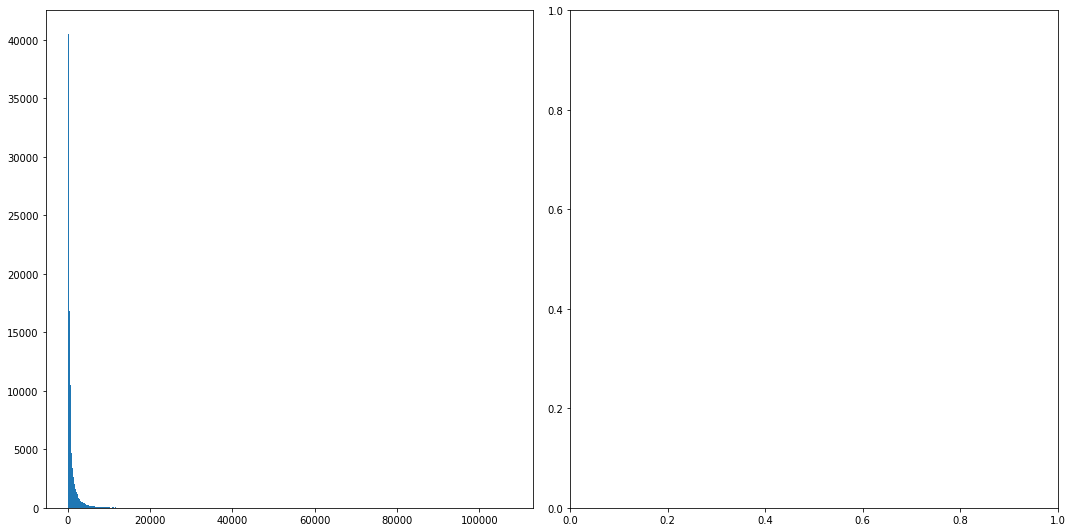

In [143]:
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
axes[0].hist(max_uid_counts, bins=500)
# sns.distplot(max_uid_counts, bins=500, ax=axes[1])
# plt.xlim(0, 1000)
fig.tight_layout()
plt.show()

In [321]:
trains_uid_counts["uid_sum"] = trains_uid_counts.loc[:, ["uid_counts_%s"%i for i in range(10)]].sum(1)
tests_uid_counts["uid_sum"] = tests_uid_counts.loc[:, ["uid_counts_%s"%i for i in range(10)]].sum(1)

In [322]:
for col in ["uid_counts_%s"%i for i in range(10)]:
    trains_uid_counts[col] = trains_uid_counts[col]/trains_uid_counts["uid_sum"]
    tests_uid_counts[col] =  tests_uid_counts[col]/tests_uid_counts["uid_sum"]

** Concat **

In [93]:
data_tr = pd.read_csv("./dataset/magic_allfeatures_tr.csv")
data_te = pd.read_csv("./dataset/magic_allfeatures_te.csv")

In [17]:
data_tr = pd.merge(features_tr_df, trains, how="outer", on="basename")
data_te = pd.merge(features_te_df, tests,  how="outer", on="basename")

In [19]:
data_tr = pd.merge(data_tr, trains_user_weekend, how="outer", on=["basename", "Target", "Id_y"])
data_te = pd.merge(data_te, tests_user_weekend,  how="outer", on=["basename", "Target", "Id_y"])

In [332]:
trains_uid_counts.Target = trains_uid_counts.Target + 1

In [335]:
data_tr = pd.merge(data_tr, trains_uid_counts, how="outer", on=["Target", "Id_y"])
data_te = pd.merge(data_te, tests_uid_counts,  how="outer", on=["Target", "Id_y"])

In [337]:
data_tr["uid_chongfu"] = data_tr["uid_sum"] - data_tr["len"]
data_te["uid_chongfu"] = data_te["uid_sum"] - data_te["len"]

In [32]:
trains_user_weekend.sort_values("basename").Target.values

array([2, 6, 6, ..., 2, 1, 1])

In [20]:
data_tr.shape, data_te.shape

((400000, 360), (100000, 360))

In [160]:
data_tr = pd.merge(data_tr, train_dl182_df, how="outer", on="basename")
data_te = pd.concat([data_te, test_dl182_df], axis=1,sort=False)

In [56]:
data_tr = pd.merge(trains.loc[:, ["basename", "Target"]], train_dl182_df, how="outer", on="basename")
data_te = test_dl182_df

In [43]:
data_tr = pd.merge(trains, features_tr_df, how="inner", on="basename")
data_te = pd.merge(tests, features_te_df,  how="inner", on="basename")

In [87]:
data_tr.shape

(400000, 136)

In [7]:
data_tr = trains.copy()
data_te = tests.copy()

In [92]:
data_tr.Id

['gq_0',
 'gq_1',
 'gq_2',
 'gq_3',
 'gq_4',
 'gq_5',
 'gq_6',
 'gq_7',
 'cj_0',
 'cj_1',
 'cj_2',
 'cj_3',
 'cj_4',
 'cj_5',
 'cj_6',
 'cj_7',
 'hjnocj_0',
 'hjnocj_1',
 'hjnocj_2',
 'hjnocj_3',
 'hjnocj_4',
 'hjnocj_5',
 'hjnocj_6',
 'hjnocj_7',
 'notjq_0',
 'notjq_1',
 'notjq_2',
 'notjq_3',
 'notjq_4',
 'notjq_5',
 'notjq_6',
 'notjq_7',
 'basename',
 'gqr_0',
 'gqr_1',
 'gqr_2',
 'gqr_3',
 'gqr_4',
 'gqr_5',
 'gqr_6',
 'gqr_7',
 'cjr_0',
 'cjr_1',
 'cjr_2',
 'cjr_3',
 'cjr_4',
 'cjr_5',
 'cjr_6',
 'cjr_7',
 'hjnocjr_0',
 'hjnocjr_1',
 'hjnocjr_2',
 'hjnocjr_3',
 'hjnocjr_4',
 'hjnocjr_5',
 'hjnocjr_6',
 'hjnocjr_7',
 'notjqr_0',
 'notjqr_1',
 'notjqr_2',
 'notjqr_3',
 'notjqr_4',
 'notjqr_5',
 'notjqr_6',
 'notjqr_7',
 'jq_endday',
 'hjnocj_endday',
 'notjq_endday',
 'gqbwr_0',
 'gqbwr_1',
 'cjbwr_0',
 'cjbwr_1',
 'hjnocjbwr_0',
 'hjnocjbwr_1',
 'notjqwr_0',
 'notjqwr_1',
 'Id_y_x',
 'Target',
 'len',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'h

In [38]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 399999
Columns: 192 entries, gq_0 to weekOend_sum_sum
dtypes: float64(182), int64(8), object(2)
memory usage: 589.0+ MB


In [94]:
data_tr.head()

,gq_0,gq_1,gq_2,gq_3,gq_4,gq_5,gq_6,gq_7,cj_0,cj_1,...,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,46.2,61.0,13.4,32.4,65.5,83.5,17.5,52.5,54.6,81.2,...,150.275862,2127.0,325.643822,14.0,19.464286,1.0,3.875700,18.464286,3.527072,2.500000
1,147.4,247.8,55.0,134.4,136.5,290.0,66.5,150.5,99.6,200.2,...,107.115290,2986.0,325.130010,6.0,20.813953,1.0,2.959325,19.813953,3.002080,1.600000
2,85.2,133.0,29.4,71.4,92.5,125.0,29.0,76.0,152.8,240.6,...,155.174807,3337.0,405.018023,14.0,21.431373,1.0,4.270332,20.431373,3.913678,2.727273
3,13.4,15.4,3.0,8.0,25.5,37.0,8.5,13.5,10.0,9.6,...,41.752542,581.0,95.627578,10.0,17.147059,1.0,3.351594,16.147059,2.746391,2.187500
4,1.0,10.4,2.4,1.2,0.0,10.5,3.5,1.0,0.0,1.2,...,30.213333,367.0,64.835647,7.0,10.333333,1.0,2.580842,9.333333,1.757457,2.181818


In [340]:
data_te.head()

,gq_0,gq_1,gq_2,gq_3,gq_4,gq_5,gq_6,gq_7,cj_0,cj_1,...,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9,sum_known,uid_sum,uid_chongfu
0,121.0,212.8,44.4,105.8,114.0,241.5,60.0,109.0,118.4,243.2,...,0.006792,0.000000,0.027380,0.026319,0.007429,0.040964,0.788178,1996.0,9423.0,8376.0
1,1.8,20.2,5.0,3.6,6.0,40.0,11.5,10.5,3.0,7.2,...,0.020686,0.000296,0.031028,0.057033,0.016253,0.037234,0.676714,1094.0,3384.0,3008.0
2,3.0,4.0,1.4,0.8,2.5,7.0,2.0,4.5,0.0,1.2,...,0.006734,0.001122,0.014590,0.043771,0.004489,0.015713,0.784512,192.0,891.0,792.0
3,44.4,108.2,25.8,55.8,63.0,124.5,26.0,60.5,59.6,112.2,...,0.004762,0.000227,0.077551,0.019048,0.010204,0.038095,0.691610,1360.0,4410.0,3920.0
4,95.4,196.0,41.6,109.0,98.5,257.0,52.5,110.5,69.6,148.4,...,0.008806,0.000562,0.018362,0.044782,0.022485,0.034008,0.731029,2871.0,10674.0,9488.0


In [27]:
(data_te.isna()).any().any()

False

In [349]:
features = feature

In [348]:
for i in ['uid_counts_9', 'uid_sum', 'uid_chongfu']:
    feature.remove(i)
#     features.remove(i)

In [21]:
feature = data_tr.columns.to_list()
for i in ['Id_y', 'Target', 'basename']:#'day_len_min'
    feature.remove(i)
print(feature)

['gq_0', 'gq_1', 'gq_2', 'gq_3', 'gq_4', 'gq_5', 'gq_6', 'gq_7', 'cj_0', 'cj_1', 'cj_2', 'cj_3', 'cj_4', 'cj_5', 'cj_6', 'cj_7', 'hjnocj_0', 'hjnocj_1', 'hjnocj_2', 'hjnocj_3', 'hjnocj_4', 'hjnocj_5', 'hjnocj_6', 'hjnocj_7', 'notjq_0', 'notjq_1', 'notjq_2', 'notjq_3', 'notjq_4', 'notjq_5', 'notjq_6', 'notjq_7', 'gqr_0', 'gqr_1', 'gqr_2', 'gqr_3', 'gqr_4', 'gqr_5', 'gqr_6', 'gqr_7', 'cjr_0', 'cjr_1', 'cjr_2', 'cjr_3', 'cjr_4', 'cjr_5', 'cjr_6', 'cjr_7', 'hjnocjr_0', 'hjnocjr_1', 'hjnocjr_2', 'hjnocjr_3', 'hjnocjr_4', 'hjnocjr_5', 'hjnocjr_6', 'hjnocjr_7', 'notjqr_0', 'notjqr_1', 'notjqr_2', 'notjqr_3', 'notjqr_4', 'notjqr_5', 'notjqr_6', 'notjqr_7', 'jq_endday', 'hjnocj_endday', 'notjq_endday', 'gqbwr_0', 'gqbwr_1', 'cjbwr_0', 'cjbwr_1', 'hjnocjbwr_0', 'hjnocjbwr_1', 'notjqwr_0', 'notjqwr_1', 'len', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'h

In [22]:
features = data_tr.columns.to_list()
for i in ['Id_y', 'Target', 'basename']:
    features.remove(i)
print(features)

['gq_0', 'gq_1', 'gq_2', 'gq_3', 'gq_4', 'gq_5', 'gq_6', 'gq_7', 'cj_0', 'cj_1', 'cj_2', 'cj_3', 'cj_4', 'cj_5', 'cj_6', 'cj_7', 'hjnocj_0', 'hjnocj_1', 'hjnocj_2', 'hjnocj_3', 'hjnocj_4', 'hjnocj_5', 'hjnocj_6', 'hjnocj_7', 'notjq_0', 'notjq_1', 'notjq_2', 'notjq_3', 'notjq_4', 'notjq_5', 'notjq_6', 'notjq_7', 'gqr_0', 'gqr_1', 'gqr_2', 'gqr_3', 'gqr_4', 'gqr_5', 'gqr_6', 'gqr_7', 'cjr_0', 'cjr_1', 'cjr_2', 'cjr_3', 'cjr_4', 'cjr_5', 'cjr_6', 'cjr_7', 'hjnocjr_0', 'hjnocjr_1', 'hjnocjr_2', 'hjnocjr_3', 'hjnocjr_4', 'hjnocjr_5', 'hjnocjr_6', 'hjnocjr_7', 'notjqr_0', 'notjqr_1', 'notjqr_2', 'notjqr_3', 'notjqr_4', 'notjqr_5', 'notjqr_6', 'notjqr_7', 'jq_endday', 'hjnocj_endday', 'notjq_endday', 'gqbwr_0', 'gqbwr_1', 'cjbwr_0', 'cjbwr_1', 'hjnocjbwr_0', 'hjnocjbwr_1', 'notjqwr_0', 'notjqwr_1', 'len', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'h

In [90]:
feature = ['sum', 'sum_div_len', 'len'] + ["dl_%s"%i for i in range(192)]

In [350]:
len(feature)

198

In [45]:
data_tr.to_csv("./dataset/magic_allfeatures_tr.csv", index=False)
data_te.to_csv("./dataset/magic_allfeatures_te.csv", index=False)

# lgb

In [85]:
gbm = lgb.Booster(model_file="./models/lgb_overfit_0.txt")

In [89]:
pred_val = m88888001.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
# print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))

acc: 0.6547211319717007


In [342]:
models

In [98]:
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    gbm = lgb.Booster(model_file="./models/lgb_overfit_%s.txt"%fold)
    pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))

fold: 0
acc: 0.6547211319717007
fold: 1
acc: 0.6518043524455944
fold: 2
acc: 0.652979337758278
fold: 3
acc: 0.6541206765084564
fold: 4
acc: 0.6561246046726752


In [182]:
train_data_list.loc[:, ["Id_y"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319999 entries, 0 to 399999
Data columns (total 1 columns):
Id_y    319999 non-null object
dtypes: object(1)
memory usage: 4.9+ MB


In [186]:
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    train_data_list.Id_y.to_csv("./temp/lgb_tr_%s.csv"%fold, index=False, header=True)
    val_data_list.Id_y.to_csv("./temp/lgb_val_%s.csv"%fold, index=False, header=True)
#     gbm = lgb.Booster(model_file="./models/lgb_overfit_%s.txt"%fold)
#     pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
#     print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4


In [38]:
# 自定义F1评价函数
def multi_logloss(pred, data_vail):
    labels = data_vail.get_label()
    pred = pred.reshape(len(np.unique(labels)), -1).T
    score_vail = log_loss(y_true=labels, y_pred=pred)
    return score_vail

In [130]:
models_leaves31 = models[1:]
models_leaves31

In [189]:
for m in models:
    print(m.best_score)

defaultdict(<class 'dict'>, {'train': {'multi_error': 0.06711814193032238, 'multi_logloss': 0.3556424806540406}, 'valid': {'multi_error': 0.3287125, 'multi_logloss': 1.0552803102528943}})
defaultdict(<class 'dict'>, {'train': {'multi_error': 0.07457756360374888, 'multi_logloss': 0.37345381265543093}, 'valid': {'multi_error': 0.3300166252078151, 'multi_logloss': 1.0548344360612225}})
defaultdict(<class 'dict'>, {'train': {'multi_error': 0.06615206725210163, 'multi_logloss': 0.3540046046793059}, 'valid': {'multi_error': 0.3280707017675442, 'multi_logloss': 1.049640041267215}})
defaultdict(<class 'dict'>, {'train': {'multi_error': 0.06667375019922435, 'multi_logloss': 0.35437236098433683}, 'valid': {'multi_error': 0.32816230608647823, 'multi_logloss': 1.0554959262398442}})
defaultdict(<class 'dict'>, {'train': {'multi_error': 0.07126383619692869, 'multi_logloss': 0.36635960666971057}, 'valid': {'multi_error': 0.32463684776358226, 'multi_logloss': 1.0447686351085812}})
defaultdict(<class '

In [23]:
models = []
pred_tests = []

In [288]:
data_tr = data_tr.loc[(data_tr.len<100000)&(data_tr["sum"]<1750000)].copy()

In [25]:
models

In [24]:
params = {
    "objective": "multiclass",
    'num_leaves': 31,
    "num_class": 9,
    "learning_rate": 0.03,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2019,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  {"multi_logloss", 'multi_error'},#
#     "first_metric_only": True,
#     "early_stopping_rounds": 1600,
    'is_unbalance': True
}
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
pred_vals = []
true_vals = []
basenames = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
    if fold in [0]:
        init_model = models[0]#_leaves31[fold]#lgb.Booster(model_file="./models/lgb/lgb_allfeatures_0.txt")
    early_stopping_rounds = 1600
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[feature].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[feature].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                init_model = init_model,
#                 feval = multi_logloss,
                early_stopping_rounds=early_stopping_rounds,
                feature_name=feature,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    basenames.append(val_data_list.basename.values)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_test = gbm.predict(data_te[feature].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_error: 0.399543	train's multi_logloss: 1.39733	valid's multi_error: 0.405565	valid's multi_logloss: 1.40669
[100]	train's multi_error: 0.392087	train's multi_logloss: 1.24059	valid's multi_error: 0.399265	valid's multi_logloss: 1.25733
[150]	train's multi_error: 0.385534	train's multi_logloss: 1.1848	valid's multi_error: 0.393528	valid's multi_logloss: 1.20945
[200]	train's multi_error: 0.380012	train's multi_logloss: 1.15425	valid's multi_error: 0.390053	valid's multi_logloss: 1.18759
[250]	train's multi_error: 0.375421	train's multi_logloss: 1.132	valid's multi_error: 0.387465	valid's multi_logloss: 1.17479
[300]	train's multi_error: 0.371784	train's multi_logloss: 1.11371	valid's multi_error: 0.385003	valid's multi_logloss: 1.16619
[350]	train's multi_error: 0.36843	train's multi_logloss: 1.09778	valid's multi_error: 0.383528	valid's multi_logloss: 1.15969
[400]	train's multi_error: 0.365559	t

[3200]	train's multi_error: 0.232033	train's multi_logloss: 0.691964	valid's multi_error: 0.352954	valid's multi_logloss: 1.06819
[3250]	train's multi_error: 0.229958	train's multi_logloss: 0.687523	valid's multi_error: 0.352391	valid's multi_logloss: 1.06742
[3300]	train's multi_error: 0.227764	train's multi_logloss: 0.683055	valid's multi_error: 0.351879	valid's multi_logloss: 1.06662
[3350]	train's multi_error: 0.225648	train's multi_logloss: 0.678685	valid's multi_error: 0.351579	valid's multi_logloss: 1.06593
[3400]	train's multi_error: 0.223605	train's multi_logloss: 0.674278	valid's multi_error: 0.351491	valid's multi_logloss: 1.0652
[3450]	train's multi_error: 0.221433	train's multi_logloss: 0.669974	valid's multi_error: 0.350954	valid's multi_logloss: 1.06454
[3500]	train's multi_error: 0.219389	train's multi_logloss: 0.665748	valid's multi_error: 0.350366	valid's multi_logloss: 1.06387
[3550]	train's multi_error: 0.217042	train's multi_logloss: 0.661476	valid's multi_error: 0

[6400]	train's multi_error: 0.120832	train's multi_logloss: 0.470234	valid's multi_error: 0.331429	valid's multi_logloss: 1.03879
[6450]	train's multi_error: 0.119698	train's multi_logloss: 0.467538	valid's multi_error: 0.331367	valid's multi_logloss: 1.03858
[6500]	train's multi_error: 0.118448	train's multi_logloss: 0.464923	valid's multi_error: 0.331342	valid's multi_logloss: 1.03832
[6550]	train's multi_error: 0.117282	train's multi_logloss: 0.462325	valid's multi_error: 0.331279	valid's multi_logloss: 1.03814
[6600]	train's multi_error: 0.11601	train's multi_logloss: 0.45971	valid's multi_error: 0.330917	valid's multi_logloss: 1.03793
[6650]	train's multi_error: 0.114694	train's multi_logloss: 0.457151	valid's multi_error: 0.330429	valid's multi_logloss: 1.03773
[6700]	train's multi_error: 0.113513	train's multi_logloss: 0.454587	valid's multi_error: 0.330567	valid's multi_logloss: 1.03756
[6750]	train's multi_error: 0.112288	train's multi_logloss: 0.452056	valid's multi_error: 0.

[9550]	train's multi_error: 0.0605691	train's multi_logloss: 0.333901	valid's multi_error: 0.320554	valid's multi_logloss: 1.03388
[9600]	train's multi_error: 0.0598566	train's multi_logloss: 0.332114	valid's multi_error: 0.320329	valid's multi_logloss: 1.03391
[9650]	train's multi_error: 0.0590879	train's multi_logloss: 0.330349	valid's multi_error: 0.320342	valid's multi_logloss: 1.03399
[9700]	train's multi_error: 0.0584597	train's multi_logloss: 0.328666	valid's multi_error: 0.320292	valid's multi_logloss: 1.0341
[9750]	train's multi_error: 0.0578004	train's multi_logloss: 0.32695	valid's multi_error: 0.320017	valid's multi_logloss: 1.03409
[9800]	train's multi_error: 0.0571629	train's multi_logloss: 0.325273	valid's multi_error: 0.319867	valid's multi_logloss: 1.03413
[9850]	train's multi_error: 0.0565972	train's multi_logloss: 0.323552	valid's multi_error: 0.319692	valid's multi_logloss: 1.03416
[9900]	train's multi_error: 0.0558285	train's multi_logloss: 0.321812	valid's multi_e

KeyboardInterrupt: 

In [39]:
pred_tests = []

In [37]:
models[-1].best_score

defaultdict(dict,
            {'train': {'multi_error': 0.0025343908399427495},
             'valid': {'multi_error': 0.31001724956876076}})

In [38]:
gbm.best_score

defaultdict(dict,
            {'train': {'multi_error': 0.0025343908399427495},
             'valid': {'multi_error': 0.31001724956876076}})

In [40]:
params = {
    "objective": "multiclass",
    'num_leaves': 31,
    "num_class": 9,
    "learning_rate": 0.03,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2019,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  { 'multi_error'},#
#     "first_metric_only": True,
#     "early_stopping_rounds": 1600,
    'is_unbalance': True
}
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
pred_vals = []
true_vals = []
basenames = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
    early_stopping_rounds = 1600
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    if fold in [0]:
        gbm = models[-1]
        pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
        pred_vals.append(pred_val)
        true_vals.append(val_data_list['Target'].values)
        basenames.append(val_data_list.basename.values)
        print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
        pred_test = gbm.predict(data_te[feature].values, num_iteration=gbm.best_iteration)
        pred_tests.append(pred_test)
        print(np.array(pred_tests).shape, pred_test.shape)
        continue
    else:
        init_model = None
    lgb_train = lgb.Dataset(train_data_list[feature].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[feature].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                init_model = init_model,
#                 feval = multi_logloss,
                early_stopping_rounds=early_stopping_rounds,
                feature_name=feature,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    basenames.append(val_data_list.basename.values)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_test = gbm.predict(data_te[feature].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
acc: 0.6899827504312392
(1, 100000, 9) (100000, 9)
fold: 1
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_error: 0.39972	valid's multi_error: 0.405182
[100]	train's multi_error: 0.391682	valid's multi_error: 0.398745
[150]	train's multi_error: 0.385736	valid's multi_error: 0.393533
[200]	train's multi_error: 0.380417	valid's multi_error: 0.39022
[250]	train's multi_error: 0.376201	valid's multi_error: 0.38782
[300]	train's multi_error: 0.372614	valid's multi_error: 0.38587
[350]	train's multi_error: 0.369486	valid's multi_error: 0.383808
[400]	train's multi_error: 0.366601	valid's multi_error: 0.382883
[450]	train's multi_error: 0.363795	valid's multi_error: 0.38127
[500]	train's multi_error: 0.361167	valid's multi_error: 0.380108
[550]	train's multi_error: 0.358779	valid's multi_error: 0.379233
[600]	train's multi_error: 0.356398	valid's multi_error: 0.378195
[650]	train's multi_error: 0.354054	valid's multi_error: 0.377433
[700]	train's mul

[6100]	train's multi_error: 0.129216	valid's multi_error: 0.330583
[6150]	train's multi_error: 0.127875	valid's multi_error: 0.330308
[6200]	train's multi_error: 0.126522	valid's multi_error: 0.329958
[6250]	train's multi_error: 0.125257	valid's multi_error: 0.329883
[6300]	train's multi_error: 0.124032	valid's multi_error: 0.329708
[6350]	train's multi_error: 0.122822	valid's multi_error: 0.329083
[6400]	train's multi_error: 0.1215	valid's multi_error: 0.328758
[6450]	train's multi_error: 0.120207	valid's multi_error: 0.328433
[6500]	train's multi_error: 0.118919	valid's multi_error: 0.328171
[6550]	train's multi_error: 0.117594	valid's multi_error: 0.328071
[6600]	train's multi_error: 0.116344	valid's multi_error: 0.328083
[6650]	train's multi_error: 0.114885	valid's multi_error: 0.327883
[6700]	train's multi_error: 0.113678	valid's multi_error: 0.327558
[6750]	train's multi_error: 0.112541	valid's multi_error: 0.327658
[6800]	train's multi_error: 0.111413	valid's multi_error: 0.3274

[12150]	train's multi_error: 0.031922	valid's multi_error: 0.314096
[12200]	train's multi_error: 0.0314845	valid's multi_error: 0.314009
[12250]	train's multi_error: 0.0310845	valid's multi_error: 0.313946
[12300]	train's multi_error: 0.0307282	valid's multi_error: 0.313646
[12350]	train's multi_error: 0.0302907	valid's multi_error: 0.313596
[12400]	train's multi_error: 0.0298845	valid's multi_error: 0.313534
[12450]	train's multi_error: 0.0295438	valid's multi_error: 0.313534
[12500]	train's multi_error: 0.0290563	valid's multi_error: 0.313484
[12550]	train's multi_error: 0.0286626	valid's multi_error: 0.313484
[12600]	train's multi_error: 0.0282251	valid's multi_error: 0.313159
[12650]	train's multi_error: 0.0278438	valid's multi_error: 0.313109
[12700]	train's multi_error: 0.027472	valid's multi_error: 0.313209
[12750]	train's multi_error: 0.0270501	valid's multi_error: 0.313071
[12800]	train's multi_error: 0.0266907	valid's multi_error: 0.313021
[12850]	train's multi_error: 0.02627

[18100]	train's multi_error: 0.00494064	valid's multi_error: 0.309771
[18150]	train's multi_error: 0.00482814	valid's multi_error: 0.309784
[18200]	train's multi_error: 0.00475626	valid's multi_error: 0.309784
[18250]	train's multi_error: 0.00465939	valid's multi_error: 0.309671
[18300]	train's multi_error: 0.00461876	valid's multi_error: 0.309596
[18350]	train's multi_error: 0.00450939	valid's multi_error: 0.309646
[18400]	train's multi_error: 0.00443126	valid's multi_error: 0.309559
[18450]	train's multi_error: 0.00435626	valid's multi_error: 0.309396
[18500]	train's multi_error: 0.00430001	valid's multi_error: 0.309484
[18550]	train's multi_error: 0.00424376	valid's multi_error: 0.309396
[18600]	train's multi_error: 0.00415626	valid's multi_error: 0.309634
[18650]	train's multi_error: 0.00408126	valid's multi_error: 0.309596
[18700]	train's multi_error: 0.00400939	valid's multi_error: 0.309509
[18750]	train's multi_error: 0.00396564	valid's multi_error: 0.309521
[18800]	train's mult

[1550]	train's multi_error: 0.311076	valid's multi_error: 0.366745
[1600]	train's multi_error: 0.30872	valid's multi_error: 0.36632
[1650]	train's multi_error: 0.306113	valid's multi_error: 0.365995
[1700]	train's multi_error: 0.303792	valid's multi_error: 0.365383
[1750]	train's multi_error: 0.301423	valid's multi_error: 0.365095
[1800]	train's multi_error: 0.298785	valid's multi_error: 0.364295
[1850]	train's multi_error: 0.296404	valid's multi_error: 0.363895
[1900]	train's multi_error: 0.293832	valid's multi_error: 0.363233
[1950]	train's multi_error: 0.291492	valid's multi_error: 0.362608
[2000]	train's multi_error: 0.289113	valid's multi_error: 0.362083
[2050]	train's multi_error: 0.286607	valid's multi_error: 0.361645
[2100]	train's multi_error: 0.284226	valid's multi_error: 0.36092
[2150]	train's multi_error: 0.281888	valid's multi_error: 0.36007
[2200]	train's multi_error: 0.279329	valid's multi_error: 0.359571
[2250]	train's multi_error: 0.27696	valid's multi_error: 0.359246


[7700]	train's multi_error: 0.0915034	valid's multi_error: 0.324396
[7750]	train's multi_error: 0.090519	valid's multi_error: 0.324296
[7800]	train's multi_error: 0.0895722	valid's multi_error: 0.324121
[7850]	train's multi_error: 0.0884409	valid's multi_error: 0.324058
[7900]	train's multi_error: 0.087644	valid's multi_error: 0.323883
[7950]	train's multi_error: 0.0866253	valid's multi_error: 0.323833
[8000]	train's multi_error: 0.0855034	valid's multi_error: 0.323658
[8050]	train's multi_error: 0.0844409	valid's multi_error: 0.323683
[8100]	train's multi_error: 0.0835815	valid's multi_error: 0.323296
[8150]	train's multi_error: 0.0827284	valid's multi_error: 0.323033
[8200]	train's multi_error: 0.0818221	valid's multi_error: 0.323108
[8250]	train's multi_error: 0.0808721	valid's multi_error: 0.322721
[8300]	train's multi_error: 0.0799315	valid's multi_error: 0.322646
[8350]	train's multi_error: 0.079019	valid's multi_error: 0.322733
[8400]	train's multi_error: 0.078019	valid's multi_

[13700]	train's multi_error: 0.0211251	valid's multi_error: 0.312346
[13750]	train's multi_error: 0.0208251	valid's multi_error: 0.312246
[13800]	train's multi_error: 0.0205407	valid's multi_error: 0.312159
[13850]	train's multi_error: 0.0202907	valid's multi_error: 0.312146
[13900]	train's multi_error: 0.0199469	valid's multi_error: 0.312334
[13950]	train's multi_error: 0.0195688	valid's multi_error: 0.312246
[14000]	train's multi_error: 0.0193344	valid's multi_error: 0.312221
[14050]	train's multi_error: 0.0190376	valid's multi_error: 0.312146
[14100]	train's multi_error: 0.0187751	valid's multi_error: 0.312321
[14150]	train's multi_error: 0.0184094	valid's multi_error: 0.311959
[14200]	train's multi_error: 0.0181001	valid's multi_error: 0.311946
[14250]	train's multi_error: 0.0178813	valid's multi_error: 0.311896
[14300]	train's multi_error: 0.0176126	valid's multi_error: 0.311884
[14350]	train's multi_error: 0.0173594	valid's multi_error: 0.312009
[14400]	train's multi_error: 0.017

[250]	train's multi_error: 0.375308	valid's multi_error: 0.388717
[300]	train's multi_error: 0.371789	valid's multi_error: 0.386567
[350]	train's multi_error: 0.368686	valid's multi_error: 0.38478
[400]	train's multi_error: 0.365705	valid's multi_error: 0.383255
[450]	train's multi_error: 0.363264	valid's multi_error: 0.382205
[500]	train's multi_error: 0.36073	valid's multi_error: 0.381417
[550]	train's multi_error: 0.35824	valid's multi_error: 0.380492
[600]	train's multi_error: 0.355865	valid's multi_error: 0.379492
[650]	train's multi_error: 0.353586	valid's multi_error: 0.378467
[700]	train's multi_error: 0.351249	valid's multi_error: 0.37788
[750]	train's multi_error: 0.348868	valid's multi_error: 0.377192
[800]	train's multi_error: 0.346386	valid's multi_error: 0.37648
[850]	train's multi_error: 0.344355	valid's multi_error: 0.376142
[900]	train's multi_error: 0.341905	valid's multi_error: 0.375342
[950]	train's multi_error: 0.339536	valid's multi_error: 0.37458
[1000]	train's m

[6400]	train's multi_error: 0.121293	valid's multi_error: 0.331517
[6450]	train's multi_error: 0.119943	valid's multi_error: 0.331479
[6500]	train's multi_error: 0.118659	valid's multi_error: 0.331079
[6550]	train's multi_error: 0.117412	valid's multi_error: 0.330667
[6600]	train's multi_error: 0.116206	valid's multi_error: 0.330417
[6650]	train's multi_error: 0.114931	valid's multi_error: 0.330442
[6700]	train's multi_error: 0.113715	valid's multi_error: 0.330004
[6750]	train's multi_error: 0.112518	valid's multi_error: 0.329854
[6800]	train's multi_error: 0.111297	valid's multi_error: 0.329417
[6850]	train's multi_error: 0.10999	valid's multi_error: 0.329279
[6900]	train's multi_error: 0.108868	valid's multi_error: 0.329017
[6950]	train's multi_error: 0.107628	valid's multi_error: 0.328917
[7000]	train's multi_error: 0.106403	valid's multi_error: 0.328517
[7050]	train's multi_error: 0.105297	valid's multi_error: 0.328317
[7100]	train's multi_error: 0.104253	valid's multi_error: 0.328

[12450]	train's multi_error: 0.0290437	valid's multi_error: 0.314791
[12500]	train's multi_error: 0.0286124	valid's multi_error: 0.314704
[12550]	train's multi_error: 0.0282218	valid's multi_error: 0.314591
[12600]	train's multi_error: 0.0278718	valid's multi_error: 0.314491
[12650]	train's multi_error: 0.0274655	valid's multi_error: 0.314391
[12700]	train's multi_error: 0.0270562	valid's multi_error: 0.314341
[12750]	train's multi_error: 0.0267062	valid's multi_error: 0.314304
[12800]	train's multi_error: 0.026353	valid's multi_error: 0.314291
[12850]	train's multi_error: 0.0258937	valid's multi_error: 0.314329
[12900]	train's multi_error: 0.0255562	valid's multi_error: 0.314391
[12950]	train's multi_error: 0.0252374	valid's multi_error: 0.314241
[13000]	train's multi_error: 0.0247749	valid's multi_error: 0.314266
[13050]	train's multi_error: 0.0244437	valid's multi_error: 0.314254
[13100]	train's multi_error: 0.0240937	valid's multi_error: 0.314079
[13150]	train's multi_error: 0.0237

[18400]	train's multi_error: 0.00428436	valid's multi_error: 0.311279
[18450]	train's multi_error: 0.00422186	valid's multi_error: 0.311091
[18500]	train's multi_error: 0.00414061	valid's multi_error: 0.311241
[18550]	train's multi_error: 0.00404061	valid's multi_error: 0.311141
[18600]	train's multi_error: 0.00400624	valid's multi_error: 0.311304
[18650]	train's multi_error: 0.00393124	valid's multi_error: 0.311329
[18700]	train's multi_error: 0.00386874	valid's multi_error: 0.311266
[18750]	train's multi_error: 0.00378124	valid's multi_error: 0.311329
[18800]	train's multi_error: 0.00374999	valid's multi_error: 0.311291
[18850]	train's multi_error: 0.00367811	valid's multi_error: 0.311304
[18900]	train's multi_error: 0.00359999	valid's multi_error: 0.311341
[18950]	train's multi_error: 0.00353436	valid's multi_error: 0.311279
[19000]	train's multi_error: 0.00348124	valid's multi_error: 0.311179
Early stopping, best iteration is:
[17429]	train's multi_error: 0.00596561	valid's multi_e

[5400]	train's multi_error: 0.15017	valid's multi_error: 0.331962
[5450]	train's multi_error: 0.148649	valid's multi_error: 0.331562
[5500]	train's multi_error: 0.147192	valid's multi_error: 0.331225
[5550]	train's multi_error: 0.145539	valid's multi_error: 0.330962
[5600]	train's multi_error: 0.14398	valid's multi_error: 0.33075
[5650]	train's multi_error: 0.142474	valid's multi_error: 0.330712
[5700]	train's multi_error: 0.140617	valid's multi_error: 0.330387
[5750]	train's multi_error: 0.139208	valid's multi_error: 0.329987
[5800]	train's multi_error: 0.137789	valid's multi_error: 0.329462
[5850]	train's multi_error: 0.136317	valid's multi_error: 0.32935
[5900]	train's multi_error: 0.134621	valid's multi_error: 0.328937
[5950]	train's multi_error: 0.133202	valid's multi_error: 0.3287
[6000]	train's multi_error: 0.131783	valid's multi_error: 0.328337
[6050]	train's multi_error: 0.130402	valid's multi_error: 0.328112
[6100]	train's multi_error: 0.128814	valid's multi_error: 0.327712
[

[11500]	train's multi_error: 0.0379653	valid's multi_error: 0.311924
[11550]	train's multi_error: 0.0375059	valid's multi_error: 0.311787
[11600]	train's multi_error: 0.037009	valid's multi_error: 0.311762
[11650]	train's multi_error: 0.0364747	valid's multi_error: 0.311537
[11700]	train's multi_error: 0.0359809	valid's multi_error: 0.311587
[11750]	train's multi_error: 0.0355278	valid's multi_error: 0.311399
[11800]	train's multi_error: 0.0349778	valid's multi_error: 0.311412
[11850]	train's multi_error: 0.0345122	valid's multi_error: 0.311362
[11900]	train's multi_error: 0.0340247	valid's multi_error: 0.311287
[11950]	train's multi_error: 0.0335341	valid's multi_error: 0.311262
[12000]	train's multi_error: 0.0331278	valid's multi_error: 0.311149
[12050]	train's multi_error: 0.0326903	valid's multi_error: 0.311099
[12100]	train's multi_error: 0.0322309	valid's multi_error: 0.311049
[12150]	train's multi_error: 0.031856	valid's multi_error: 0.310824
[12200]	train's multi_error: 0.03137

[17450]	train's multi_error: 0.00617494	valid's multi_error: 0.306949
[17500]	train's multi_error: 0.00609682	valid's multi_error: 0.307087
[17550]	train's multi_error: 0.00596244	valid's multi_error: 0.306937
[17600]	train's multi_error: 0.00589369	valid's multi_error: 0.307024
[17650]	train's multi_error: 0.00579995	valid's multi_error: 0.306949
[17700]	train's multi_error: 0.00570307	valid's multi_error: 0.306924
[17750]	train's multi_error: 0.0056062	valid's multi_error: 0.306899
[17800]	train's multi_error: 0.00548432	valid's multi_error: 0.306787
[17850]	train's multi_error: 0.00539057	valid's multi_error: 0.306762
[17900]	train's multi_error: 0.00526558	valid's multi_error: 0.306849
[17950]	train's multi_error: 0.00517183	valid's multi_error: 0.306799
[18000]	train's multi_error: 0.00509995	valid's multi_error: 0.306799
[18050]	train's multi_error: 0.0050187	valid's multi_error: 0.307024
[18100]	train's multi_error: 0.00492183	valid's multi_error: 0.306899
[18150]	train's multi_

In [66]:
feature = list(feature)

In [68]:
pred_tests = []
params = {
    "objective": "multiclass",
    'num_leaves': 31,
    "num_class": 9,
    "learning_rate": 0.03,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2019,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  {'multi_error'},#
#     "first_metric_only": True,
#     "early_stopping_rounds": 1600,
    'is_unbalance': True
}
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
pred_tests = []
pred_vals = []
true_vals = []
basenames = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
#     if fold in [0]:
    init_model = None #models_leaves31[fold]#lgb.Booster(model_file="./models/lgb/lgb_allfeatures_0.txt")
    early_stopping_rounds = 1600
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[feature].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[feature].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                init_model = init_model,
#                 feval = multi_logloss,
                early_stopping_rounds=early_stopping_rounds,
                feature_name=feature,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    basenames.append(val_data_list.basename.values)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_test = gbm.predict(data_te[feature].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_error: 0.40029	valid's multi_error: 0.405065
[100]	train's multi_error: 0.392071	valid's multi_error: 0.398728
[150]	train's multi_error: 0.385637	valid's multi_error: 0.393578
[200]	train's multi_error: 0.380196	valid's multi_error: 0.389665
[250]	train's multi_error: 0.375784	valid's multi_error: 0.387315
[300]	train's multi_error: 0.371921	valid's multi_error: 0.38489
[350]	train's multi_error: 0.368652	valid's multi_error: 0.383353
[400]	train's multi_error: 0.365874	valid's multi_error: 0.382153
[500]	train's multi_error: 0.360734	valid's multi_error: 0.380428
[550]	train's multi_error: 0.35823	valid's multi_error: 0.379853


KeyboardInterrupt: 

In [61]:
params = {
    "objective": "multiclass",
    'num_leaves': 31,
    "num_class": 9,
    "learning_rate": 0.03,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2019,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  {'multi_error'},#
#     "first_metric_only": True,
#     "early_stopping_rounds": 1600,
    'is_unbalance': True
}
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
pred_vals = []
true_vals = []
basenames = []
pred_tests = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
#     if fold in [0]:
#         pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
#         pred_vals.append(pred_val)
#         true_vals.append(val_data_list['Target'].values)
#         basenames.append(val_data_list.basename.values)
#         print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
#         pred_test = gbm.predict(data_te[feature].values, num_iteration=gbm.best_iteration)
#         pred_tests.append(pred_test)
#         print(np.array(pred_tests).shape, pred_test.shape)
    init_model = models[fold] #models_leaves31[fold]#lgb.Booster(model_file="./models/lgb/lgb_allfeatures_0.txt")
    early_stopping_rounds = 1600
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[feature].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[feature].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                init_model = init_model,
#                 feval = multi_logloss,
                early_stopping_rounds=early_stopping_rounds,
                feature_name=feature,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    basenames.append(val_data_list.basename.values)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_test = gbm.predict(data_te[feature].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
Training until validation scores don't improve for 1600 rounds.
[10150]	train's multi_error: 0.066465	valid's multi_error: 0.328738
[10200]	train's multi_error: 0.0658462	valid's multi_error: 0.32875
[10250]	train's multi_error: 0.0652368	valid's multi_error: 0.328587
[10300]	train's multi_error: 0.0645899	valid's multi_error: 0.328375
[10350]	train's multi_error: 0.0638993	valid's multi_error: 0.3283
[10400]	train's multi_error: 0.0633993	valid's multi_error: 0.32815
[10450]	train's multi_error: 0.0627867	valid's multi_error: 0.328138
[10500]	train's multi_error: 0.0620836	valid's multi_error: 0.327987
[10550]	train's multi_error: 0.0613929	valid's multi_error: 0.3277
[10600]	train's multi_error: 0.0607773	valid's multi_error: 0.327838
[10650]	train's multi_error: 0.0602366	valid's multi_error: 0.327838
[10700]	train's multi_error: 0.059621	valid's multi_error: 0.327625
[10750]	train's multi_error: 0.0589803	valid's multi_error: 0.327425
[10800]	train's multi_error: 0.0583678	

[16100]	train's multi_error: 0.0166131	valid's multi_error: 0.319837
[16150]	train's multi_error: 0.0164069	valid's multi_error: 0.319812
[16200]	train's multi_error: 0.0162194	valid's multi_error: 0.319725
[16250]	train's multi_error: 0.0159693	valid's multi_error: 0.319763
[16300]	train's multi_error: 0.0157787	valid's multi_error: 0.31965
[16350]	train's multi_error: 0.0155818	valid's multi_error: 0.319862
[16400]	train's multi_error: 0.0152943	valid's multi_error: 0.319788
[16450]	train's multi_error: 0.0150412	valid's multi_error: 0.319638
[16500]	train's multi_error: 0.0148912	valid's multi_error: 0.319625
[16550]	train's multi_error: 0.014663	valid's multi_error: 0.319588
[16600]	train's multi_error: 0.0144599	valid's multi_error: 0.319387
[16650]	train's multi_error: 0.0142224	valid's multi_error: 0.3193
[16700]	train's multi_error: 0.0140412	valid's multi_error: 0.319362
[16750]	train's multi_error: 0.0138193	valid's multi_error: 0.319375
[16800]	train's multi_error: 0.0136099

[22050]	train's multi_error: 0.00254072	valid's multi_error: 0.31765
[22100]	train's multi_error: 0.00250634	valid's multi_error: 0.3176
[22150]	train's multi_error: 0.00247197	valid's multi_error: 0.317713
[22200]	train's multi_error: 0.00242509	valid's multi_error: 0.317613
[22250]	train's multi_error: 0.00236259	valid's multi_error: 0.317713
[22300]	train's multi_error: 0.00232509	valid's multi_error: 0.31765
[22350]	train's multi_error: 0.00228759	valid's multi_error: 0.31765
[22400]	train's multi_error: 0.00226258	valid's multi_error: 0.317725
[22450]	train's multi_error: 0.00224071	valid's multi_error: 0.317725
[22500]	train's multi_error: 0.00220633	valid's multi_error: 0.317625
[22550]	train's multi_error: 0.00216258	valid's multi_error: 0.31765
[22600]	train's multi_error: 0.00213446	valid's multi_error: 0.317763
[22650]	train's multi_error: 0.00210633	valid's multi_error: 0.31775
[22700]	train's multi_error: 0.00207508	valid's multi_error: 0.317812
[22750]	train's multi_error

[13900]	train's multi_error: 0.0297791	valid's multi_error: 0.322629
[13950]	train's multi_error: 0.029376	valid's multi_error: 0.322517
[14000]	train's multi_error: 0.0290291	valid's multi_error: 0.322542
[14050]	train's multi_error: 0.0287291	valid's multi_error: 0.322479
[14100]	train's multi_error: 0.0284197	valid's multi_error: 0.322292
[14150]	train's multi_error: 0.0280916	valid's multi_error: 0.322242
[14200]	train's multi_error: 0.0277353	valid's multi_error: 0.322242
[14250]	train's multi_error: 0.0273478	valid's multi_error: 0.322329
[14300]	train's multi_error: 0.0270072	valid's multi_error: 0.322204
[14350]	train's multi_error: 0.026654	valid's multi_error: 0.322029
[14400]	train's multi_error: 0.0263509	valid's multi_error: 0.322079
[14450]	train's multi_error: 0.0260384	valid's multi_error: 0.321867
[14500]	train's multi_error: 0.0257415	valid's multi_error: 0.321654
[14550]	train's multi_error: 0.0253946	valid's multi_error: 0.321679
[14600]	train's multi_error: 0.02506

[19850]	train's multi_error: 0.00514393	valid's multi_error: 0.318666
[19900]	train's multi_error: 0.0050783	valid's multi_error: 0.318529
[19950]	train's multi_error: 0.0049908	valid's multi_error: 0.318579
[20000]	train's multi_error: 0.00490329	valid's multi_error: 0.318554
[20050]	train's multi_error: 0.00482829	valid's multi_error: 0.318541
[20100]	train's multi_error: 0.00471891	valid's multi_error: 0.318704
[20150]	train's multi_error: 0.00464703	valid's multi_error: 0.318766
[20200]	train's multi_error: 0.00459078	valid's multi_error: 0.318816
[20250]	train's multi_error: 0.00452828	valid's multi_error: 0.318741
[20300]	train's multi_error: 0.00448765	valid's multi_error: 0.318654
[20350]	train's multi_error: 0.00438453	valid's multi_error: 0.318579
[20400]	train's multi_error: 0.0042939	valid's multi_error: 0.318566
[20450]	train's multi_error: 0.00421577	valid's multi_error: 0.318629
[20500]	train's multi_error: 0.00414702	valid's multi_error: 0.318641
[20550]	train's multi_e

[14350]	train's multi_error: 0.0266977	valid's multi_error: 0.320421
[14400]	train's multi_error: 0.0263664	valid's multi_error: 0.320571
[14450]	train's multi_error: 0.0260164	valid's multi_error: 0.320496
[14500]	train's multi_error: 0.0257102	valid's multi_error: 0.320446
[14550]	train's multi_error: 0.0253289	valid's multi_error: 0.320508
[14600]	train's multi_error: 0.0250602	valid's multi_error: 0.320308
[14650]	train's multi_error: 0.0247351	valid's multi_error: 0.320383
[14700]	train's multi_error: 0.0243633	valid's multi_error: 0.320458
[14750]	train's multi_error: 0.0240695	valid's multi_error: 0.320308
[14800]	train's multi_error: 0.0237789	valid's multi_error: 0.320496
[14850]	train's multi_error: 0.0234851	valid's multi_error: 0.320408
[14900]	train's multi_error: 0.023157	valid's multi_error: 0.320258
[14950]	train's multi_error: 0.0228945	valid's multi_error: 0.320058
[15000]	train's multi_error: 0.0225476	valid's multi_error: 0.31997
[15050]	train's multi_error: 0.02224

[10850]	train's multi_error: 0.0576172	valid's multi_error: 0.326637
[10900]	train's multi_error: 0.0569766	valid's multi_error: 0.326625
[10950]	train's multi_error: 0.0564235	valid's multi_error: 0.326537
[11000]	train's multi_error: 0.0558328	valid's multi_error: 0.326775
[11050]	train's multi_error: 0.0553203	valid's multi_error: 0.326525
[11100]	train's multi_error: 0.0547922	valid's multi_error: 0.326612
[11150]	train's multi_error: 0.0542422	valid's multi_error: 0.326475
[11200]	train's multi_error: 0.0536671	valid's multi_error: 0.326287
[11250]	train's multi_error: 0.053139	valid's multi_error: 0.326262
[11300]	train's multi_error: 0.0526734	valid's multi_error: 0.326087
[11350]	train's multi_error: 0.0521733	valid's multi_error: 0.326037
[11400]	train's multi_error: 0.0516233	valid's multi_error: 0.326037
[11450]	train's multi_error: 0.0510046	valid's multi_error: 0.3258
[11500]	train's multi_error: 0.0505233	valid's multi_error: 0.32575
[11550]	train's multi_error: 0.0500139

[16850]	train's multi_error: 0.013266	valid's multi_error: 0.318674
[16900]	train's multi_error: 0.0130879	valid's multi_error: 0.318712
[16950]	train's multi_error: 0.0128972	valid's multi_error: 0.318762
[17000]	train's multi_error: 0.0126972	valid's multi_error: 0.318774
[17050]	train's multi_error: 0.0124629	valid's multi_error: 0.318549
[17100]	train's multi_error: 0.012341	valid's multi_error: 0.318574
[17150]	train's multi_error: 0.0121691	valid's multi_error: 0.318487
[17200]	train's multi_error: 0.0119691	valid's multi_error: 0.318449
[17250]	train's multi_error: 0.011841	valid's multi_error: 0.318462
[17300]	train's multi_error: 0.0116753	valid's multi_error: 0.318424
[17350]	train's multi_error: 0.0115097	valid's multi_error: 0.318374
[17400]	train's multi_error: 0.0113347	valid's multi_error: 0.318399
[17450]	train's multi_error: 0.0111847	valid's multi_error: 0.318412
[17500]	train's multi_error: 0.0110441	valid's multi_error: 0.318299
[17550]	train's multi_error: 0.010837

[22750]	train's multi_error: 0.00205318	valid's multi_error: 0.317362
[22800]	train's multi_error: 0.00202506	valid's multi_error: 0.317299
[22850]	train's multi_error: 0.00200318	valid's multi_error: 0.317274
[22900]	train's multi_error: 0.00195318	valid's multi_error: 0.317512
[22950]	train's multi_error: 0.00191568	valid's multi_error: 0.317387
[23000]	train's multi_error: 0.0019063	valid's multi_error: 0.317424
[23050]	train's multi_error: 0.0018688	valid's multi_error: 0.317312
[23100]	train's multi_error: 0.00184068	valid's multi_error: 0.317162
[23150]	train's multi_error: 0.00180318	valid's multi_error: 0.317124
[23200]	train's multi_error: 0.00177818	valid's multi_error: 0.317312
[23250]	train's multi_error: 0.0017563	valid's multi_error: 0.317399
[23300]	train's multi_error: 0.00173755	valid's multi_error: 0.317424
[23350]	train's multi_error: 0.00171255	valid's multi_error: 0.317449
[23400]	train's multi_error: 0.00169067	valid's multi_error: 0.317324
[23450]	train's multi_e

[13650]	train's multi_error: 0.0312818	valid's multi_error: 0.318586
[13700]	train's multi_error: 0.030935	valid's multi_error: 0.318624
[13750]	train's multi_error: 0.0305599	valid's multi_error: 0.318561
[13800]	train's multi_error: 0.0301724	valid's multi_error: 0.318524
[13850]	train's multi_error: 0.0298068	valid's multi_error: 0.318461
[13900]	train's multi_error: 0.0294724	valid's multi_error: 0.318536
[13950]	train's multi_error: 0.0290505	valid's multi_error: 0.318511
[14000]	train's multi_error: 0.028788	valid's multi_error: 0.318236
[14050]	train's multi_error: 0.0284318	valid's multi_error: 0.318211
[14100]	train's multi_error: 0.0281255	valid's multi_error: 0.317924
[14150]	train's multi_error: 0.0277443	valid's multi_error: 0.317999
[14200]	train's multi_error: 0.0273849	valid's multi_error: 0.317999
[14250]	train's multi_error: 0.0269849	valid's multi_error: 0.317974
[14300]	train's multi_error: 0.0266661	valid's multi_error: 0.317974
[14350]	train's multi_error: 0.02632

[19600]	train's multi_error: 0.00577198	valid's multi_error: 0.315499
[19650]	train's multi_error: 0.00566886	valid's multi_error: 0.315449
[19700]	train's multi_error: 0.0055751	valid's multi_error: 0.315549
[19750]	train's multi_error: 0.00549698	valid's multi_error: 0.315474
[19800]	train's multi_error: 0.00543135	valid's multi_error: 0.315611
[19850]	train's multi_error: 0.0053376	valid's multi_error: 0.315611
[19900]	train's multi_error: 0.00527197	valid's multi_error: 0.315524
[19950]	train's multi_error: 0.00515635	valid's multi_error: 0.315524
[20000]	train's multi_error: 0.00503759	valid's multi_error: 0.315411
[20050]	train's multi_error: 0.00493759	valid's multi_error: 0.315461
[20100]	train's multi_error: 0.00487197	valid's multi_error: 0.315374
[20150]	train's multi_error: 0.00480947	valid's multi_error: 0.315149
[20200]	train's multi_error: 0.00473759	valid's multi_error: 0.315149
[20250]	train's multi_error: 0.00463134	valid's multi_error: 0.315124
[20300]	train's multi_

In [37]:
gbm.save_model("./models/lgb/lgb_allfeatures_0.txt")

In [79]:
outliars_tr = data_tr[~data_tr.basename.isin(np.hstack(basenames))]

In [42]:
np.vstack(pred_vals).shape, np.hstack(basenames).shape, np.hstack(true_vals).shape

((400000, 9), (400000,), (400000,))

In [80]:
pred_val = gbm.predict(outliars_tr[feature].values, num_iteration=gbm.best_iteration)
pred_vals.append(pred_val)
true_vals.append(outliars_tr['Target'].values)
basenames.append(outliars_tr.basename.values)
print("acc:",accuracy_score(outliars_tr['Target'].values,np.argmax(pred_val,axis=1)))

acc: 0.9166666666666666


In [152]:
y_pred = np.argmax(np.vstack(pred_vals), 1)
print("lgb model:", accuracy_score(np.hstack(true_vals), y_pred))

lgb model: 0.67688


In [38]:
y_pred = np.argmax(np.vstack(pred_vals), 1)
print("lgb model:", accuracy_score(np.hstack(true_vals), y_pred))

lgb model: 0.6627152024338401


In [54]:
y_pred = np.argmax(np.vstack(pred_vals), 1)
print("lgb model:", accuracy_score(np.hstack(true_vals), y_pred))

lgb model: 0.6750880403621512


In [52]:
y_pred = np.argmax(np.vstack(pred_vals), 1)
print("lgb model:", accuracy_score(np.hstack(true_vals), y_pred))

lgb model: 0.6720801624048721


In [190]:
y_pred = np.argmax(np.vstack(pred_vals), 1)
print("lgb model:", accuracy_score(np.hstack(true_vals), y_pred))

lgb model: 0.682925


In [41]:
y_pred = np.argmax(np.vstack(pred_vals), 1)
print("lgb model:", accuracy_score(np.hstack(true_vals), y_pred))

lgb model: 0.6909775


In [43]:
np.save("./stacking/lgb_probs_train_003_adduserstats_weekend_bestacc70+_oof.npy", np.hstack([np.vstack(pred_vals), np.hstack(basenames).reshape(-1, 1), np.hstack(true_vals).reshape(-1, 1)]))

In [124]:
basenames = []
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    basenames.append(val_data_list.basename.values)

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4


In [193]:
Id_y_tr = []
Id_y_val = []
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    Id_y_tr.append(train_data_list.Id_y.values)
    Id_y_val.append(val_data_list.Id_y.values)

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4


In [199]:
np.save("./temp/lgb_Idy_tr.csv", Id_y_tr)
np.save("./temp/lgb_Idy_val.csv", Id_y_val)

In [195]:
np.hstack(Id_y_tr).shape, np.hstack(Id_y_val).shape

((1600000,), (400000,))

In [43]:
params = {
    "objective": "multiclass",
    'num_leaves': 28,
    "num_class": 9,
    "learning_rate": 0.02,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2019,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics": 'multi_error',
    'is_unbalance': True
}
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
pred_vals = []
true_vals = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print('fold:', fold)
    if fold in [0]:
#         init_model = lgb.Booster(model_file="./models/lgb/lgb_allfeatures_0.txt")
        pass
    else:
        init_model = None
    train_data_list = data_tr.iloc[train_idx]
    val_data_list = data_tr.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[feature].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[feature].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
#                 feval=multi_logloss,
                feature_name=features,
                early_stopping_rounds=1600,
                init_model = init_model,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[feature].values, num_iteration=gbm.best_iteration)
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_test = gbm.predict(data_te[feature].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
Training until validation scores don't improve for 1600 rounds.
[6100]	train's multi_error: 0.184136	valid's multi_error: 0.346391
[6150]	train's multi_error: 0.182636	valid's multi_error: 0.346366
[6200]	train's multi_error: 0.18132	valid's multi_error: 0.346404
[6250]	train's multi_error: 0.17996	valid's multi_error: 0.346266
[6300]	train's multi_error: 0.178701	valid's multi_error: 0.346416
[6350]	train's multi_error: 0.177307	valid's multi_error: 0.346516
[6400]	train's multi_error: 0.17601	valid's multi_error: 0.346391
[6450]	train's multi_error: 0.174732	valid's multi_error: 0.346141
[6500]	train's multi_error: 0.173532	valid's multi_error: 0.346216
[6550]	train's multi_error: 0.17227	valid's multi_error: 0.346029
[6600]	train's multi_error: 0.170879	valid's multi_error: 0.346041
[6650]	train's multi_error: 0.169642	valid's multi_error: 0.346041
[6700]	train's multi_error: 0.16826	valid's multi_error: 0.346091
[6750]	train's multi_error: 0.166939	valid's multi_error: 0.34

[12150]	train's multi_error: 0.0695223	valid's multi_error: 0.343141
[12200]	train's multi_error: 0.0689504	valid's multi_error: 0.343191
[12250]	train's multi_error: 0.0683254	valid's multi_error: 0.343141
[12300]	train's multi_error: 0.0677598	valid's multi_error: 0.343129
[12350]	train's multi_error: 0.0672473	valid's multi_error: 0.343054
[12400]	train's multi_error: 0.0666317	valid's multi_error: 0.343166
[12450]	train's multi_error: 0.0659129	valid's multi_error: 0.343229
[12500]	train's multi_error: 0.0652848	valid's multi_error: 0.343066
[12550]	train's multi_error: 0.0646973	valid's multi_error: 0.343079
[12600]	train's multi_error: 0.064141	valid's multi_error: 0.343191
[12650]	train's multi_error: 0.063566	valid's multi_error: 0.343191
[12700]	train's multi_error: 0.0629254	valid's multi_error: 0.343254
[12750]	train's multi_error: 0.0623004	valid's multi_error: 0.343329
[12800]	train's multi_error: 0.0617879	valid's multi_error: 0.343329
[12850]	train's multi_error: 0.06107

[18100]	train's multi_error: 0.0196251	valid's multi_error: 0.341229
[18150]	train's multi_error: 0.0193876	valid's multi_error: 0.341166
[18200]	train's multi_error: 0.0191189	valid's multi_error: 0.341166
[18250]	train's multi_error: 0.0189001	valid's multi_error: 0.341116
[18300]	train's multi_error: 0.0186376	valid's multi_error: 0.341166
[18350]	train's multi_error: 0.0183407	valid's multi_error: 0.341204
[18400]	train's multi_error: 0.0181376	valid's multi_error: 0.341216
[18450]	train's multi_error: 0.017897	valid's multi_error: 0.341304
[18500]	train's multi_error: 0.0177064	valid's multi_error: 0.341254
[18550]	train's multi_error: 0.0174282	valid's multi_error: 0.341341
[18600]	train's multi_error: 0.0172189	valid's multi_error: 0.341316
[18650]	train's multi_error: 0.017072	valid's multi_error: 0.341229
[18700]	train's multi_error: 0.0168095	valid's multi_error: 0.341154
[18750]	train's multi_error: 0.0165657	valid's multi_error: 0.341304
[18800]	train's multi_error: 0.01629

[900]	train's multi_error: 0.331367	valid's multi_error: 0.352471
[950]	train's multi_error: 0.330135	valid's multi_error: 0.352571
[1000]	train's multi_error: 0.328845	valid's multi_error: 0.352171
[1050]	train's multi_error: 0.327676	valid's multi_error: 0.351983
[1100]	train's multi_error: 0.326479	valid's multi_error: 0.351621
[1150]	train's multi_error: 0.325185	valid's multi_error: 0.351421
[1200]	train's multi_error: 0.323976	valid's multi_error: 0.351296
[1250]	train's multi_error: 0.322782	valid's multi_error: 0.351046
[1300]	train's multi_error: 0.321492	valid's multi_error: 0.350946
[1350]	train's multi_error: 0.320048	valid's multi_error: 0.350846
[1400]	train's multi_error: 0.318907	valid's multi_error: 0.350633
[1450]	train's multi_error: 0.317654	valid's multi_error: 0.350483
[1500]	train's multi_error: 0.31662	valid's multi_error: 0.350458
[1550]	train's multi_error: 0.315295	valid's multi_error: 0.350483
[1600]	train's multi_error: 0.313979	valid's multi_error: 0.35023

[7050]	train's multi_error: 0.159575	valid's multi_error: 0.343333
[7100]	train's multi_error: 0.1583	valid's multi_error: 0.343508
[7150]	train's multi_error: 0.157072	valid's multi_error: 0.343358
[7200]	train's multi_error: 0.155888	valid's multi_error: 0.343321
[7250]	train's multi_error: 0.154772	valid's multi_error: 0.343233
[7300]	train's multi_error: 0.153525	valid's multi_error: 0.343183
[7350]	train's multi_error: 0.152291	valid's multi_error: 0.343221
[7400]	train's multi_error: 0.151147	valid's multi_error: 0.343033
[7450]	train's multi_error: 0.150125	valid's multi_error: 0.342971
[7500]	train's multi_error: 0.14896	valid's multi_error: 0.343071
[7550]	train's multi_error: 0.147954	valid's multi_error: 0.343058
[7600]	train's multi_error: 0.146732	valid's multi_error: 0.343046
[7650]	train's multi_error: 0.145597	valid's multi_error: 0.343121
[7700]	train's multi_error: 0.14451	valid's multi_error: 0.343183
[7750]	train's multi_error: 0.143382	valid's multi_error: 0.343196

[13100]	train's multi_error: 0.0581908	valid's multi_error: 0.340446
[13150]	train's multi_error: 0.0576564	valid's multi_error: 0.340621
[13200]	train's multi_error: 0.0572189	valid's multi_error: 0.340333
[13250]	train's multi_error: 0.0566564	valid's multi_error: 0.340358
[13300]	train's multi_error: 0.0561846	valid's multi_error: 0.340358
[13350]	train's multi_error: 0.0556908	valid's multi_error: 0.340421
[13400]	train's multi_error: 0.0552064	valid's multi_error: 0.340358
[13450]	train's multi_error: 0.0546845	valid's multi_error: 0.340408
[13500]	train's multi_error: 0.0541783	valid's multi_error: 0.340446
[13550]	train's multi_error: 0.0537064	valid's multi_error: 0.340371
[13600]	train's multi_error: 0.0531595	valid's multi_error: 0.340283
[13650]	train's multi_error: 0.0526033	valid's multi_error: 0.340496
[13700]	train's multi_error: 0.0521752	valid's multi_error: 0.340358
[13750]	train's multi_error: 0.0517502	valid's multi_error: 0.340333
[13800]	train's multi_error: 0.051

[4650]	train's multi_error: 0.225138	valid's multi_error: 0.343096
[4700]	train's multi_error: 0.223694	valid's multi_error: 0.343058
[4750]	train's multi_error: 0.222185	valid's multi_error: 0.343033
[4800]	train's multi_error: 0.220738	valid's multi_error: 0.343008
[4850]	train's multi_error: 0.219326	valid's multi_error: 0.342971
[4900]	train's multi_error: 0.217779	valid's multi_error: 0.342683
[4950]	train's multi_error: 0.216438	valid's multi_error: 0.342796
[5000]	train's multi_error: 0.214923	valid's multi_error: 0.342621
[5050]	train's multi_error: 0.213635	valid's multi_error: 0.342483
[5100]	train's multi_error: 0.212166	valid's multi_error: 0.342446
[5150]	train's multi_error: 0.21066	valid's multi_error: 0.342321
[5200]	train's multi_error: 0.209163	valid's multi_error: 0.342171
[5250]	train's multi_error: 0.207688	valid's multi_error: 0.342258
[5300]	train's multi_error: 0.206276	valid's multi_error: 0.342283
[5350]	train's multi_error: 0.204826	valid's multi_error: 0.342

[10800]	train's multi_error: 0.0867909	valid's multi_error: 0.338783
[10850]	train's multi_error: 0.0860659	valid's multi_error: 0.338808
[10900]	train's multi_error: 0.0854159	valid's multi_error: 0.338608
[10950]	train's multi_error: 0.0846753	valid's multi_error: 0.338721
[11000]	train's multi_error: 0.0838346	valid's multi_error: 0.338708
[11050]	train's multi_error: 0.0831815	valid's multi_error: 0.338571
[11100]	train's multi_error: 0.0824878	valid's multi_error: 0.338758
[11150]	train's multi_error: 0.0816315	valid's multi_error: 0.338608
[11200]	train's multi_error: 0.0810159	valid's multi_error: 0.338421
[11250]	train's multi_error: 0.0804846	valid's multi_error: 0.338358
[11300]	train's multi_error: 0.0798252	valid's multi_error: 0.338458
[11350]	train's multi_error: 0.0790909	valid's multi_error: 0.338446
[11400]	train's multi_error: 0.0784534	valid's multi_error: 0.338433
[11450]	train's multi_error: 0.0777846	valid's multi_error: 0.338546
[11500]	train's multi_error: 0.077

[16750]	train's multi_error: 0.0273626	valid's multi_error: 0.337621
[16800]	train's multi_error: 0.027022	valid's multi_error: 0.337446
[16850]	train's multi_error: 0.026647	valid's multi_error: 0.337408
[16900]	train's multi_error: 0.0263188	valid's multi_error: 0.337571
[16950]	train's multi_error: 0.0260501	valid's multi_error: 0.337558
[17000]	train's multi_error: 0.0257501	valid's multi_error: 0.337483
[17050]	train's multi_error: 0.0254657	valid's multi_error: 0.337571
[17100]	train's multi_error: 0.0251532	valid's multi_error: 0.337558
[17150]	train's multi_error: 0.0249407	valid's multi_error: 0.337558
[17200]	train's multi_error: 0.0246126	valid's multi_error: 0.337483
[17250]	train's multi_error: 0.0243563	valid's multi_error: 0.337458
[17300]	train's multi_error: 0.0241032	valid's multi_error: 0.337583
[17350]	train's multi_error: 0.0238001	valid's multi_error: 0.337483
[17400]	train's multi_error: 0.0235657	valid's multi_error: 0.337421
Early stopping, best iteration is:
[

[5300]	train's multi_error: 0.205909	valid's multi_error: 0.346017
[5350]	train's multi_error: 0.204437	valid's multi_error: 0.345917
[5400]	train's multi_error: 0.202996	valid's multi_error: 0.345804
[5450]	train's multi_error: 0.201615	valid's multi_error: 0.345854
[5500]	train's multi_error: 0.200156	valid's multi_error: 0.345742
[5550]	train's multi_error: 0.198843	valid's multi_error: 0.345754
[5600]	train's multi_error: 0.197421	valid's multi_error: 0.345629
[5650]	train's multi_error: 0.195937	valid's multi_error: 0.345579
[5700]	train's multi_error: 0.194531	valid's multi_error: 0.345604
[5750]	train's multi_error: 0.193118	valid's multi_error: 0.345642
[5800]	train's multi_error: 0.191737	valid's multi_error: 0.345567
[5850]	train's multi_error: 0.190509	valid's multi_error: 0.345529
[5900]	train's multi_error: 0.189109	valid's multi_error: 0.345454
[5950]	train's multi_error: 0.187593	valid's multi_error: 0.345417
[6000]	train's multi_error: 0.186353	valid's multi_error: 0.34

[11400]	train's multi_error: 0.0781998	valid's multi_error: 0.342704
[11450]	train's multi_error: 0.0775154	valid's multi_error: 0.342742
[11500]	train's multi_error: 0.076931	valid's multi_error: 0.342504
[11550]	train's multi_error: 0.0761716	valid's multi_error: 0.342667
[11600]	train's multi_error: 0.0756216	valid's multi_error: 0.342617
[11650]	train's multi_error: 0.0749654	valid's multi_error: 0.342567
[11700]	train's multi_error: 0.0743248	valid's multi_error: 0.342567
[11750]	train's multi_error: 0.0736716	valid's multi_error: 0.342404
[11800]	train's multi_error: 0.0730904	valid's multi_error: 0.342292
[11850]	train's multi_error: 0.0724216	valid's multi_error: 0.342279
[11900]	train's multi_error: 0.0718342	valid's multi_error: 0.342254
[11950]	train's multi_error: 0.0712842	valid's multi_error: 0.342329
[12000]	train's multi_error: 0.0706498	valid's multi_error: 0.342329
[12050]	train's multi_error: 0.0698623	valid's multi_error: 0.342317
[12100]	train's multi_error: 0.0692

[17350]	train's multi_error: 0.0237156	valid's multi_error: 0.340867
[17400]	train's multi_error: 0.0234031	valid's multi_error: 0.340892
[17450]	train's multi_error: 0.0232218	valid's multi_error: 0.340804
[17500]	train's multi_error: 0.0228468	valid's multi_error: 0.340829
[17550]	train's multi_error: 0.0225749	valid's multi_error: 0.340929
[17600]	train's multi_error: 0.0223124	valid's multi_error: 0.340904
[17650]	train's multi_error: 0.0220093	valid's multi_error: 0.340929
[17700]	train's multi_error: 0.0217656	valid's multi_error: 0.340804
[17750]	train's multi_error: 0.0215312	valid's multi_error: 0.340792
[17800]	train's multi_error: 0.0212437	valid's multi_error: 0.340829
[17850]	train's multi_error: 0.0210281	valid's multi_error: 0.340679
[17900]	train's multi_error: 0.0207687	valid's multi_error: 0.340617
[17950]	train's multi_error: 0.0205437	valid's multi_error: 0.340704
[18000]	train's multi_error: 0.0202593	valid's multi_error: 0.340817
[18050]	train's multi_error: 0.019

[400]	train's multi_error: 0.347712	valid's multi_error: 0.357226
[450]	train's multi_error: 0.345722	valid's multi_error: 0.356226
[500]	train's multi_error: 0.343781	valid's multi_error: 0.355638
[550]	train's multi_error: 0.341997	valid's multi_error: 0.354738
[600]	train's multi_error: 0.340222	valid's multi_error: 0.353988
[650]	train's multi_error: 0.338756	valid's multi_error: 0.353163
[700]	train's multi_error: 0.337369	valid's multi_error: 0.352838
[750]	train's multi_error: 0.336103	valid's multi_error: 0.352226
[800]	train's multi_error: 0.334625	valid's multi_error: 0.351838
[850]	train's multi_error: 0.333309	valid's multi_error: 0.351626
[900]	train's multi_error: 0.331972	valid's multi_error: 0.351463
[950]	train's multi_error: 0.330691	valid's multi_error: 0.351126
[1000]	train's multi_error: 0.329463	valid's multi_error: 0.350713
[1050]	train's multi_error: 0.3283	valid's multi_error: 0.350126
[1100]	train's multi_error: 0.327103	valid's multi_error: 0.349788
[1150]	tr

[6550]	train's multi_error: 0.172261	valid's multi_error: 0.341413
[6600]	train's multi_error: 0.17098	valid's multi_error: 0.34125
[6650]	train's multi_error: 0.169689	valid's multi_error: 0.341263
[6700]	train's multi_error: 0.168408	valid's multi_error: 0.341263
[6750]	train's multi_error: 0.167208	valid's multi_error: 0.341263
[6800]	train's multi_error: 0.165895	valid's multi_error: 0.341275
[6850]	train's multi_error: 0.164633	valid's multi_error: 0.34125
[6900]	train's multi_error: 0.163195	valid's multi_error: 0.341163
[6950]	train's multi_error: 0.162011	valid's multi_error: 0.3411
[7000]	train's multi_error: 0.160739	valid's multi_error: 0.341038
[7050]	train's multi_error: 0.159455	valid's multi_error: 0.341075
[7100]	train's multi_error: 0.158202	valid's multi_error: 0.340975
[7150]	train's multi_error: 0.156958	valid's multi_error: 0.34085
[7200]	train's multi_error: 0.155739	valid's multi_error: 0.340925
[7250]	train's multi_error: 0.154558	valid's multi_error: 0.34095
[7

[12650]	train's multi_error: 0.0637213	valid's multi_error: 0.338613
[12700]	train's multi_error: 0.0631432	valid's multi_error: 0.3385
[12750]	train's multi_error: 0.062615	valid's multi_error: 0.338625
[12800]	train's multi_error: 0.0620338	valid's multi_error: 0.33865
[12850]	train's multi_error: 0.0614963	valid's multi_error: 0.33865
[12900]	train's multi_error: 0.0610182	valid's multi_error: 0.338438
[12950]	train's multi_error: 0.0604026	valid's multi_error: 0.338463
[13000]	train's multi_error: 0.0597901	valid's multi_error: 0.338525
[13050]	train's multi_error: 0.0592619	valid's multi_error: 0.338488
[13100]	train's multi_error: 0.0587682	valid's multi_error: 0.338525
[13150]	train's multi_error: 0.0582182	valid's multi_error: 0.338463
[13200]	train's multi_error: 0.0576932	valid's multi_error: 0.338575
[13250]	train's multi_error: 0.0571432	valid's multi_error: 0.338663
[13300]	train's multi_error: 0.0565963	valid's multi_error: 0.33855
[13350]	train's multi_error: 0.0560901	v

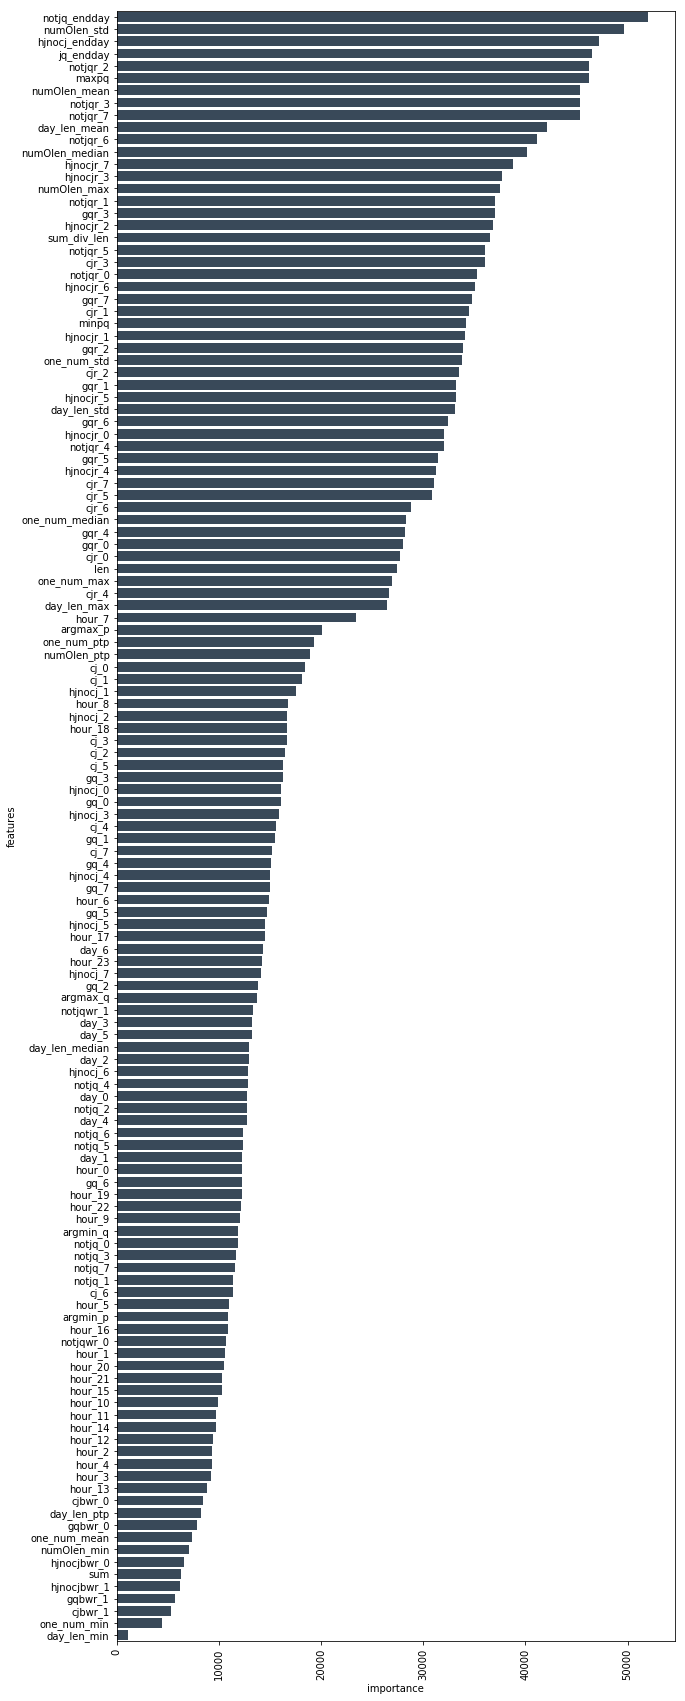

In [105]:
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,30)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

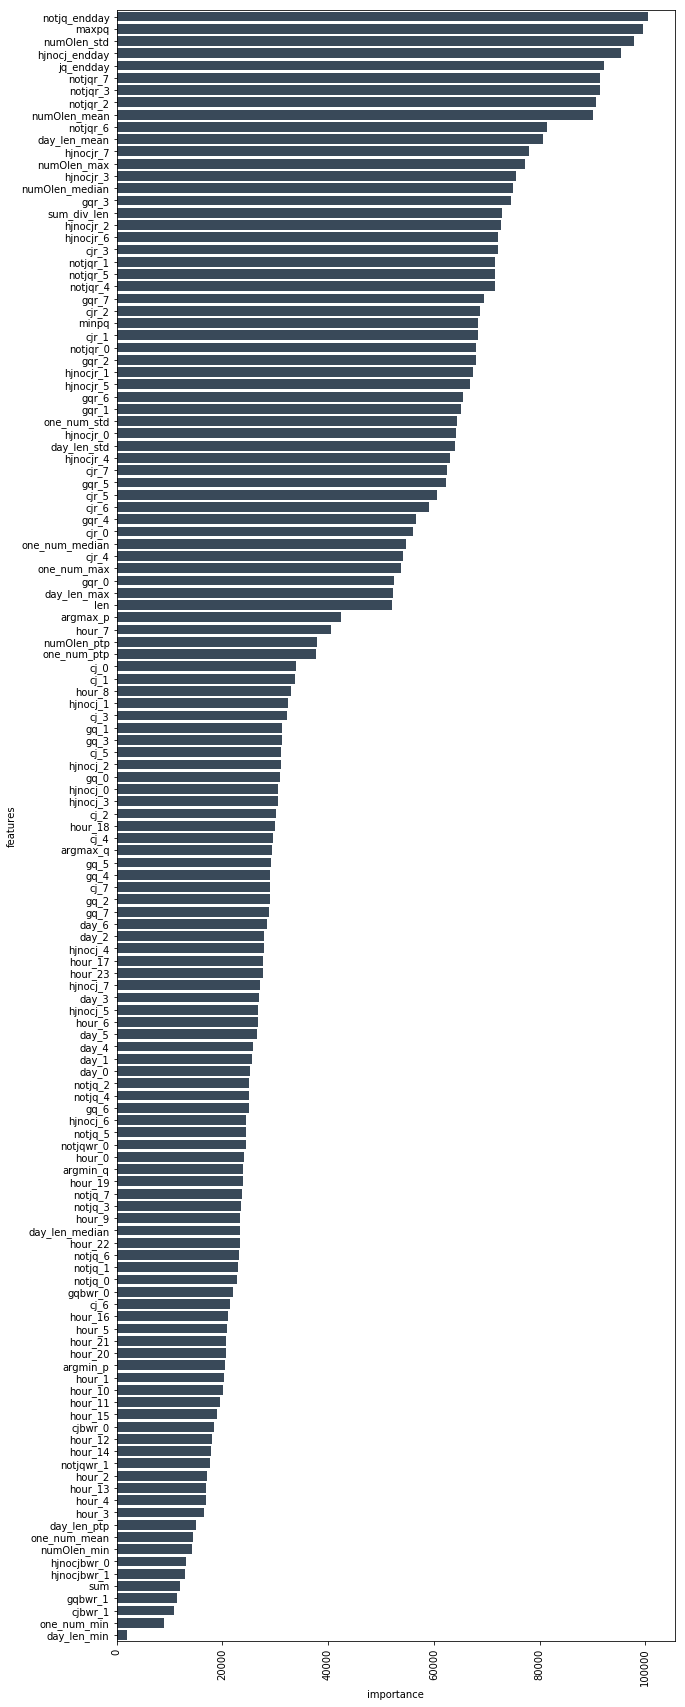

In [59]:
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,30)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

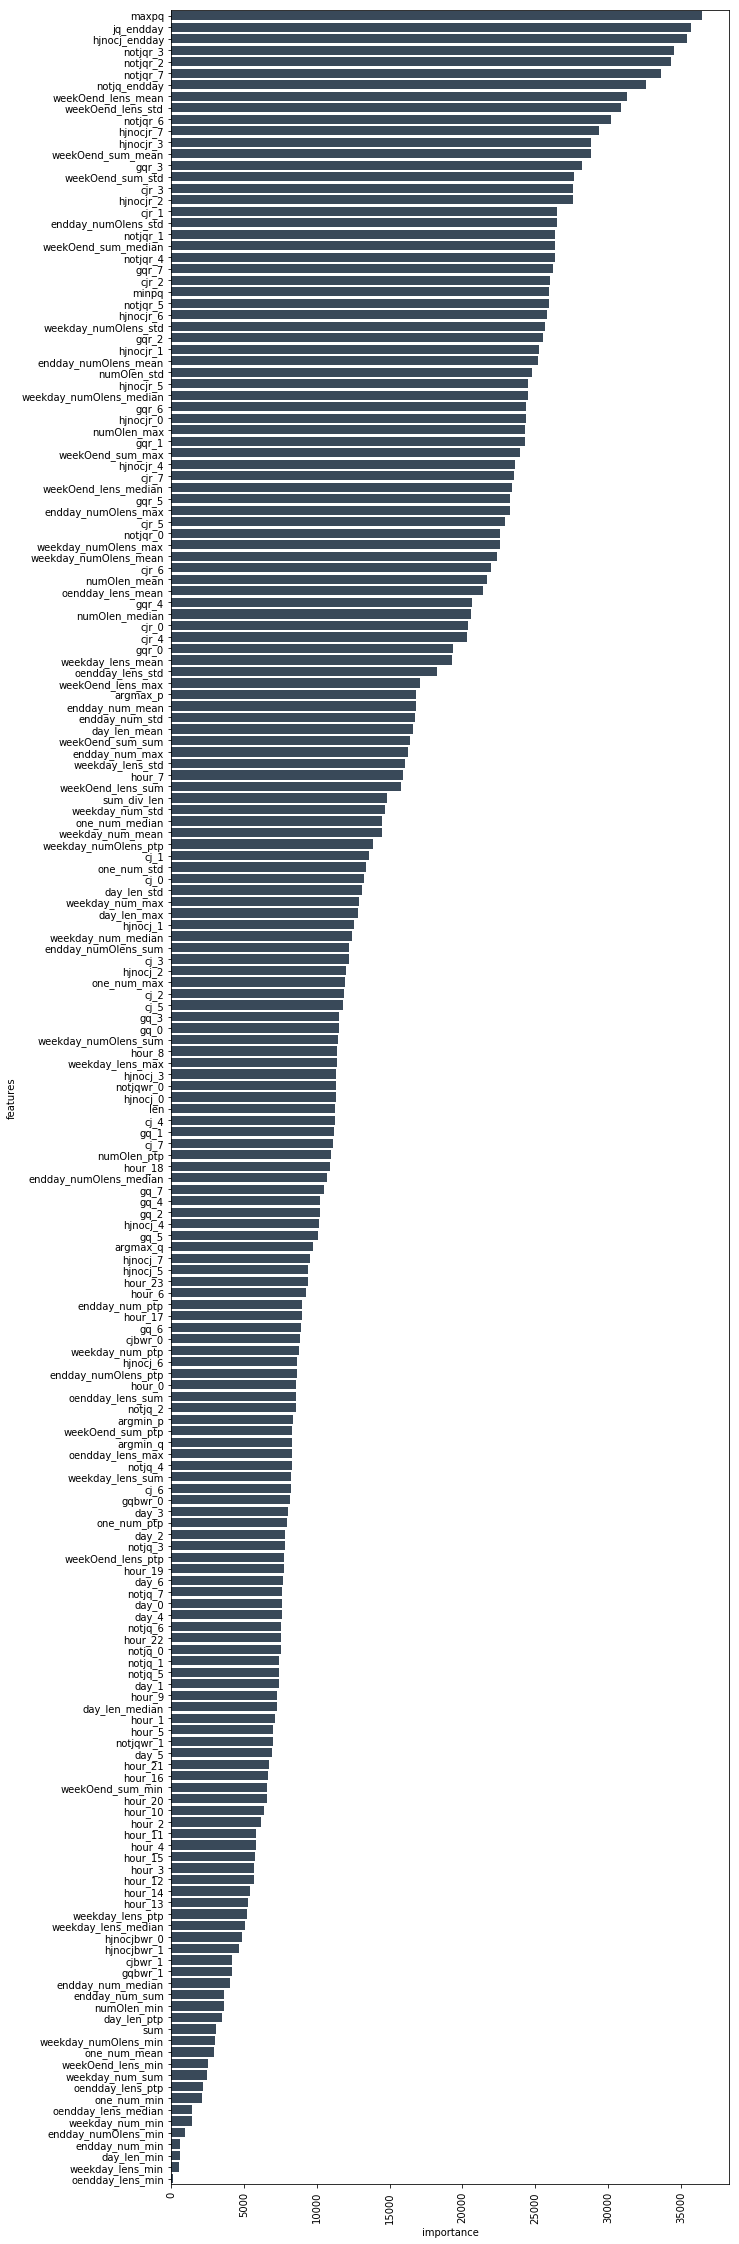

In [57]:
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,40)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

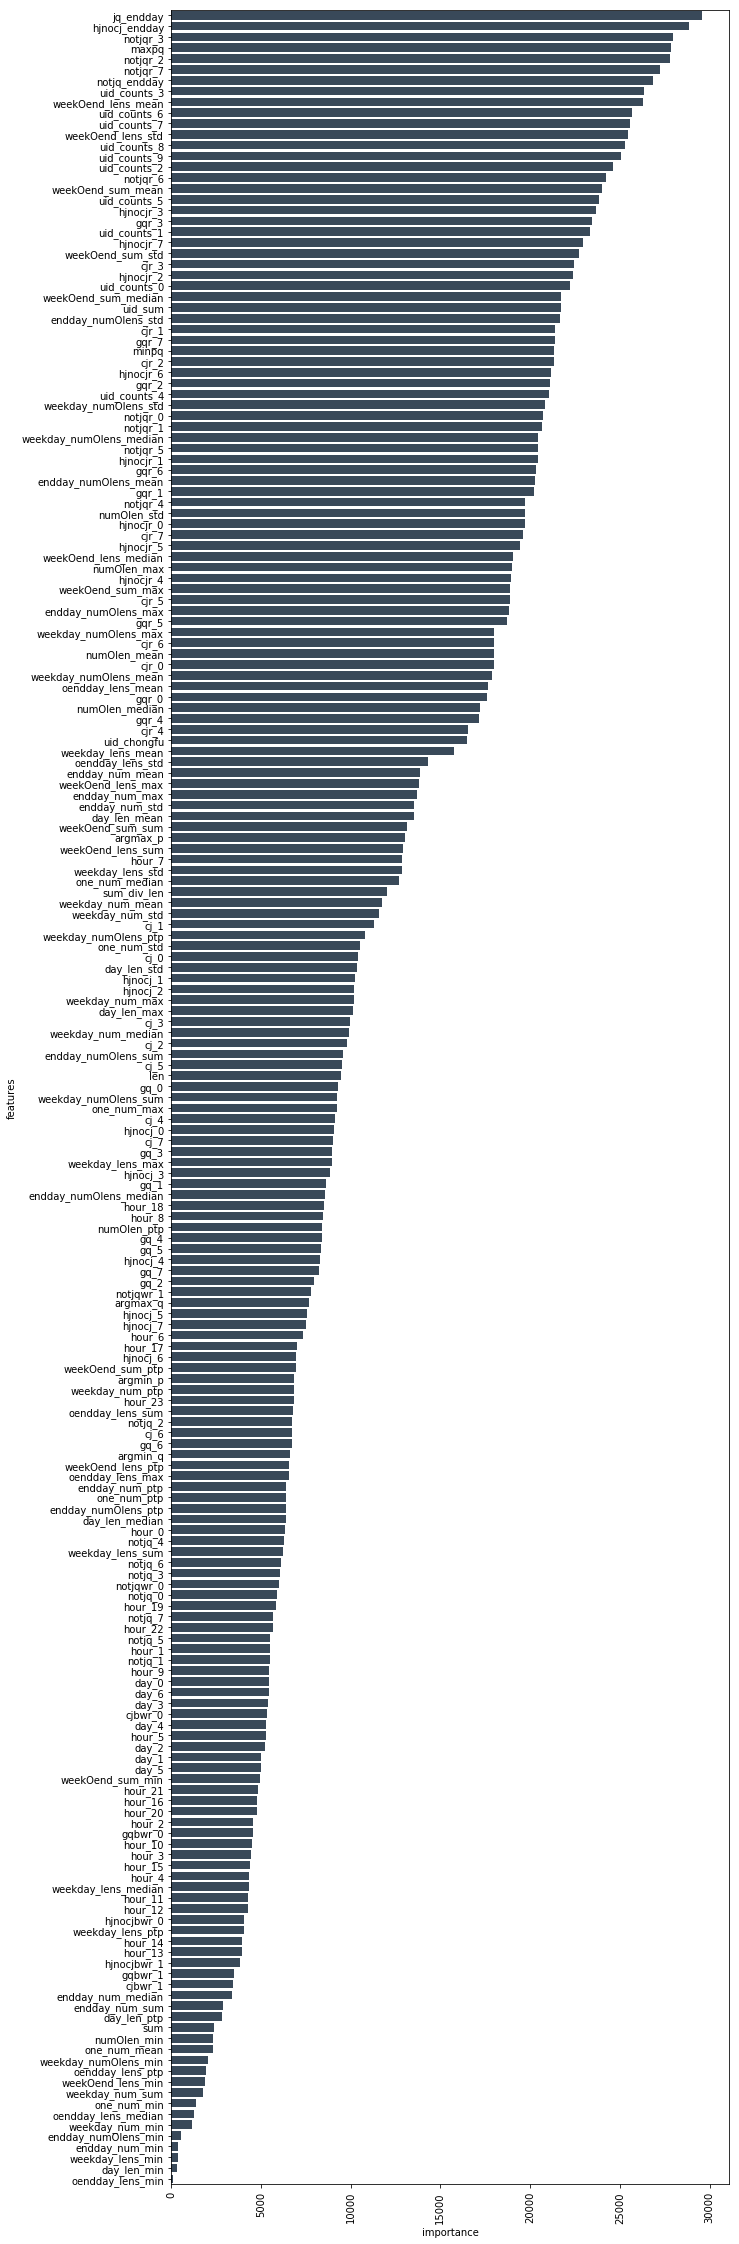

In [344]:
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,40)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

In [45]:
import seaborn as sns

/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


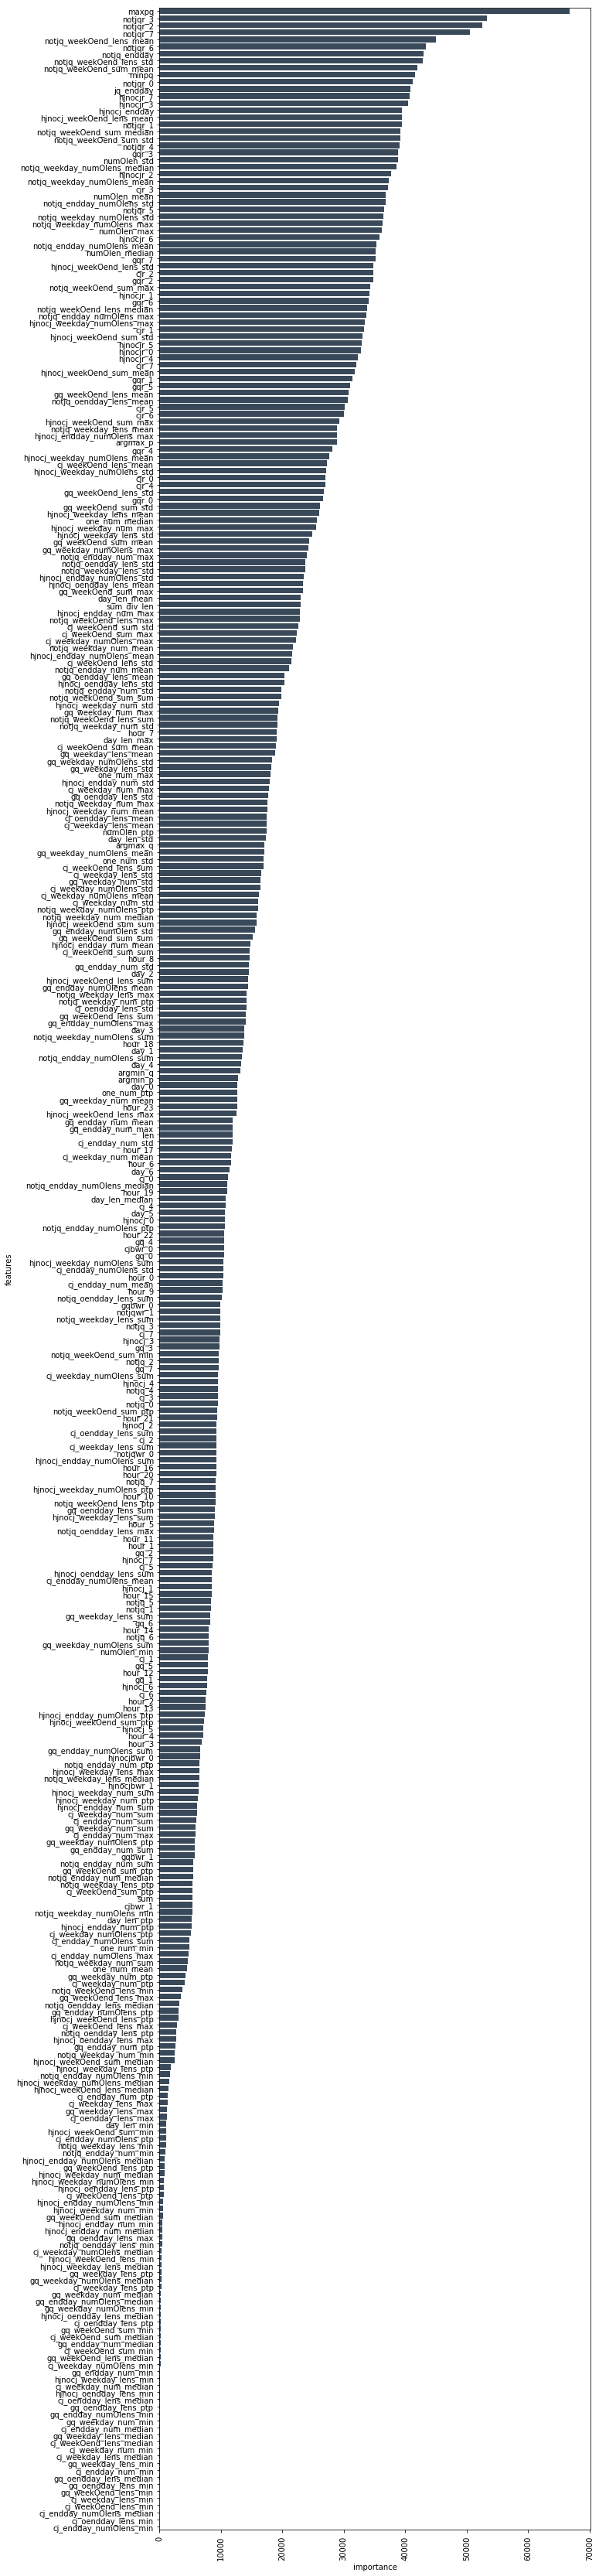

In [46]:
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,60)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

In [63]:
feature = features.loc[features.importance>888].features.values

In [64]:
feature

array(['maxpq', 'notjqr_3', 'notjqr_2', 'notjqr_7',
       'notjq_weekOend_lens_mean', 'notjqr_6', 'notjq_endday',
       'notjq_weekOend_lens_std', 'notjq_weekOend_sum_mean', 'minpq',
       'notjqr_0', 'jq_endday', 'hjnocjr_7', 'hjnocjr_3', 'hjnocj_endday',
       'hjnocj_weekOend_lens_mean', 'notjqr_1',
       'notjq_weekOend_sum_median', 'notjq_weekOend_sum_std', 'notjqr_4',
       'gqr_3', 'numOlen_std', 'notjq_weekday_numOlens_median',
       'hjnocjr_2', 'notjq_weekday_numOlens_mean', 'cjr_3',
       'numOlen_mean', 'notjq_endday_numOlens_std', 'notjqr_5',
       'notjq_weekday_numOlens_std', 'notjq_weekday_numOlens_max',
       'numOlen_max', 'hjnocjr_6', 'notjq_endday_numOlens_mean',
       'numOlen_median', 'gqr_7', 'hjnocj_weekOend_lens_std', 'cjr_2',
       'gqr_2', 'notjq_weekOend_sum_max', 'hjnocjr_1', 'gqr_6',
       'notjq_weekOend_lens_median', 'notjq_endday_numOlens_max',
       'hjnocj_weekday_numOlens_max', 'cjr_1', 'hjnocj_weekOend_sum_std',
       'hjnocjr_5', 'hj

In [47]:
result = np.mean(pred_tests, 0)
# result = np.argmax(result,axis=1)
print(result.shape)

(100000, 9)


In [48]:
idx = data_te.sort_values("basename").index.to_list()
np.array(result)[idx].shape

(100000, 9)

In [166]:
np.save("./results/lgb_probs_test_002.npy", pred_tests[:, idx])

In [146]:
np.save("./results/0713_lgb_probs_test_meanfold_overfit002.npy", np.array(result)[idx])

In [143]:
np.save("./stacking/lgb_probs_test_meanfold_adduserinfo_bestacc69.npy", np.array(result)[idx])

In [68]:
np.save("./stacking/lgb_probs_test_meanfold_adduserinfo_weekend_outliars_bestacc697.npy", np.array(result)[idx])

In [49]:
np.save("./stacking/lgb_probs_test_meanfold_adduserinfo_weekend_outliars_bestacc70+.npy", np.array(result)[idx])

## Save models

In [51]:
c = 0
for gbm in models[-5: ]:
    gbm.save_model("./models/lgb/lgb_overfit_adduserstats_weekend_outliars_bestacc70+_%s.txt"%c)
    c += 1

In [52]:
c

5

## Generate features of train set & test set

In [159]:
result_tr = []
# for im in range(5):
#     print("Loading model ", im)
#     gbm = lgb.Booster(model_file="./models/lgb_%s.txt"%im)
for im in range(5):
    print("Loading model ", im)
    gbm = models[im]#lgb.Booster(model_file="./models/lgb_overfit002_%s.txt"%im)#models[im]
    t0 = time.time()
    N = data_tr.shape[0]
    print(N)
    num_cpu = 20 # cpu数量
    pool = mlp.Pool(num_cpu)

    results = []
    batch_num = N // num_cpu
    print('batch_num',batch_num)
    for i in range(num_cpu):
        if i == num_cpu-1:
            offset = N
        else:
            offset = (i+1)*batch_num
        task_train = data_tr.iloc[i*batch_num : offset]
        print('task',i,'shape',len(task_train))
        result = pool.apply_async(gbm.predict,(task_train[feature].values,gbm.best_iteration))
        results.append(result)
    pool.close()
    pool.join()
    print('finished',len(results))

    trains = []
    for result in tqdm(results):
        trains.append(result.get())
    trains = np.vstack(trains)
    result_tr.append(trains)
    t1 = time.time()
    print('time', int(t1 - t0), 's')
    print(len(trains))

Loading model  0
400000
batch_num 20000
task 0 shape 20000
task 1 shape 20000
task 2 shape 20000
task 3 shape 20000
task 4 shape 20000
task 5 shape 20000
task 6 shape 20000
task 7 shape 20000
task 8 shape 20000
task 9 shape 20000
task 10 shape 20000
task 11 shape 20000
task 12 shape 20000
task 13 shape 20000
task 14 shape 20000
task 15 shape 20000
task 16 shape 20000
task 17 shape 20000
task 18 shape 20000
task 19 shape 20000


100%|██████████| 20/20 [00:00<00:00, 42006.05it/s]

finished 20
time 2765 s
400000
Loading model  1
400000


batch_num 20000
task 0 shape 20000
task 1 shape 20000
task 2 shape 20000
task 3 shape 20000
task 4 shape 20000
task 5 shape 20000
task 6 shape 20000
task 7 shape 20000
task 8 shape 20000
task 9 shape 20000
task 10 shape 20000
task 11 shape 20000
task 12 shape 20000
task 13 shape 20000
task 14 shape 20000
task 15 shape 20000
task 16 shape 20000
task 17 shape 20000
task 18 shape 20000
task 19 shape 20000


100%|██████████| 20/20 [00:00<00:00, 32400.96it/s]

finished 20
time 773 s
400000
Loading model  2
400000


batch_num 20000
task 0 shape 20000
task 1 shape 20000
task 2 shape 20000
task 3 shape 20000
task 4 shape 20000
task 5 shape 20000
task 6 shape 20000
task 7 shape 20000
task 8 shape 20000
task 9 shape 20000
task 10 shape 20000
task 11 shape 20000
task 12 shape 20000
task 13 shape 20000
task 14 shape 20000
task 15 shape 20000
task 16 shape 20000
task 17 shape 20000
task 18 shape 20000
task 19 shape 20000


100%|██████████| 20/20 [00:00<00:00, 30393.51it/s]

finished 20
time 1362 s
400000
Loading model  3
400000


batch_num 20000
task 0 shape 20000
task 1 shape 20000
task 2 shape 20000
task 3 shape 20000
task 4 shape 20000
task 5 shape 20000
task 6 shape 20000
task 7 shape 20000
task 8 shape 20000
task 9 shape 20000
task 10 shape 20000
task 11 shape 20000
task 12 shape 20000
task 13 shape 20000
task 14 shape 20000
task 15 shape 20000
task 16 shape 20000
task 17 shape 20000
task 18 shape 20000
task 19 shape 20000


100%|██████████| 20/20 [00:00<00:00, 37633.95it/s]

finished 20
time 1270 s
400000
Loading model  4
400000


batch_num 20000
task 0 shape 20000
task 1 shape 20000
task 2 shape 20000
task 3 shape 20000
task 4 shape 20000
task 5 shape 20000
task 6 shape 20000
task 7 shape 20000
task 8 shape 20000
task 9 shape 20000
task 10 shape 20000
task 11 shape 20000
task 12 shape 20000
task 13 shape 20000
task 14 shape 20000
task 15 shape 20000
task 16 shape 20000
task 17 shape 20000
task 18 shape 20000
task 19 shape 20000


100%|██████████| 20/20 [00:00<00:00, 30537.34it/s]

finished 20
time 1337 s
400000


In [167]:
result_tr = np.array(result_tr)
print(result_tr.shape)
idx = data_tr.sort_values("basename").index.to_list()
np.save("./results/lgb_probs_train_002.npy", result_tr[:, idx])

(5, 400000, 9)


In [ ]:
outoffold_tr = result_tr.copy()
for fold, (train_idx, val_idx) in enumerate(skf.split(data_tr, data_tr['Target'])):
    print((train_idx, val_idx))
    outoffold_tr[fold, train_idx] = 0

In [205]:
np.save("./results/lgb_probs_train_002_oot.npy", np.sum(outoffold_tr, axis=(0))[idx])

In [75]:
result_te = []
# for im in range(5):
#     print("Loading model ", im)
#     gbm = lgb.Booster(model_file="./models/lgb_%s.txt"%im)
for im in range(1, 5):
    print("Loading model ", im)
    gbm = models[im]
    t0 = time.time()
    N = data_te.shape[0]
    print(N)
    num_cpu = 20 # cpu数量
    pool = mlp.Pool(num_cpu)

    results = []
    batch_num = N // num_cpu
    print('batch_num',batch_num)
    for i in range(num_cpu):
        if i == num_cpu-1:
            offset = N
        else:
            offset = (i+1)*batch_num
        task_tests = data_te.iloc[i*batch_num : offset]
        print('task',i,'shape',len(task_tests))
        result = pool.apply_async(gbm.predict, (task_tests[feature].values, gbm.best_iteration))
        results.append(result)
    pool.close()
    pool.join()
    print('finished',len(results))

    tests = []
    for result in tqdm(results):
        tests.append(result.get())
    tests = np.vstack(tests)
    result_te.append(tests)
    t1 = time.time()
    print('time', int(t1 - t0), 's')
    print(len(tests))

Loading model  1
100000
batch_num 5000
task 0 shape 5000
task 1 shape 5000
task 2 shape 5000
task 3 shape 5000
task 4 shape 5000
task 5 shape 5000
task 6 shape 5000
task 7 shape 5000
task 8 shape 5000
task 9 shape 5000
task 10 shape 5000
task 11 shape 5000
task 12 shape 5000
task 13 shape 5000
task 14 shape 5000
task 15 shape 5000
task 16 shape 5000
task 17 shape 5000
task 18 shape 5000
task 19 shape 5000


100%|██████████| 20/20 [00:00<00:00, 55590.51it/s]

finished 20
time 161 s
100000
Loading model  2
100000


batch_num 5000
task 0 shape 5000
task 1 shape 5000
task 2 shape 5000
task 3 shape 5000
task 4 shape 5000
task 5 shape 5000
task 6 shape 5000
task 7 shape 5000
task 8 shape 5000
task 9 shape 5000
task 10 shape 5000
task 11 shape 5000
task 12 shape 5000
task 13 shape 5000
task 14 shape 5000
task 15 shape 5000
task 16 shape 5000
task 17 shape 5000
task 18 shape 5000
task 19 shape 5000


100%|██████████| 20/20 [00:00<00:00, 47446.88it/s]

finished 20
time 164 s
100000
Loading model  3
100000


batch_num 5000
task 0 shape 5000
task 1 shape 5000
task 2 shape 5000
task 3 shape 5000
task 4 shape 5000
task 5 shape 5000
task 6 shape 5000
task 7 shape 5000
task 8 shape 5000
task 9 shape 5000
task 10 shape 5000
task 11 shape 5000
task 12 shape 5000
task 13 shape 5000
task 14 shape 5000
task 15 shape 5000
task 16 shape 5000
task 17 shape 5000
task 18 shape 5000
task 19 shape 5000


100%|██████████| 20/20 [00:00<00:00, 37449.14it/s]

finished 20
time 166 s
100000
Loading model  4
100000


batch_num 5000
task 0 shape 5000
task 1 shape 5000
task 2 shape 5000
task 3 shape 5000
task 4 shape 5000
task 5 shape 5000
task 6 shape 5000
task 7 shape 5000
task 8 shape 5000
task 9 shape 5000
task 10 shape 5000
task 11 shape 5000
task 12 shape 5000
task 13 shape 5000
task 14 shape 5000
task 15 shape 5000
task 16 shape 5000
task 17 shape 5000
task 18 shape 5000
task 19 shape 5000


100%|██████████| 20/20 [00:00<00:00, 43195.72it/s]

finished 20
time 166 s
100000


In [76]:
result_te = np.array(result_te)
print(result_te.shape)
idx = data_te.sort_values("basename").index.to_list()
np.save("./results/lgb_probs_test.npy", result_te[:, idx])

(5, 100000, 9)


In [ ]:
with open("./results/lgb_results_tr.pkl", "wb") as f:
    pickle.dump(result_tr, f)
with open("./results/lgb_results_te.pkl", "wb") as f:
    pickle.dump(result_te, f)

In [18]:
np.save("./results/lgb_probs_test.npy", result_te)

In [64]:
result_argm = np.argmax(result,axis=1)

In [65]:
sample_submission_df = data_te.loc[:, ["basename", "Target"]]#pd.read_csv("./test.csv")
del sample_submission_df['Target']
sample_submission_df.columns = ['AreaID']
# sample_submission_df['AreaID'] = sample_submission_df['AreaID'].apply(lambda x: str(x).zfill(6))
sample_submission_df['CategoryID'] = [str(x+1).zfill(3) for x in result_argm]
sample_submission_df.sort_values(by='AreaID', inplace=True)
sample_submission_df[['AreaID','CategoryID']].to_csv('./submit/0729_lgb_result_overfit_adduserstats_weekend_outliars_bestacc.txt', sep="\t", header=False, index=False)

In [66]:
sample_submission_df

,AreaID,CategoryID
0,000000,001
1,000001,003
2,000002,003
3,000003,001
4,000004,001
5,000005,006
6,000006,001
7,000007,003
8,000008,002
9,000009,003
